In [1]:
import matplotlib.pyplot as plt
import random, shutil, pickle, sys
import numpy as np
from collections import deque
from keras import Sequential
from keras.optimizers import RMSprop
from IPython.display import display
from PIL import Image
import pandas as pd
from keras import Model
import keras, os, glob
import tensorflow as tf
from keras.layers import Layer, Dense, Flatten, RepeatVector,Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from keras.layers import Activation, Bidirectional ,Dropout
from keras import layers
# import cv2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import codecs
import csv
import secrets
import sqlite3
from IPython.display import display
from IPython.display import clear_output
import time
from tabulate import tabulate
import json
import datetime
from tensorflow.keras.optimizers import Adam
import math, datetime

In [4]:
class ChartDecorator:
    def __init__(self):
        self.balance_limit = 300
        self.standard_balance = 1000
        self.prev_trade = None
        
    def add_top_bottom_bar(self, img, draw_context):
        # Define the coordinates of the black bar
        x1, y1 = 0, 204
        x2, y2 = 200, 224
        # Draw the black bar bottom bar
        draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
        # Draw the black bar top bar
        x1, y1 = 0, 0
        x2, y2 = 224, 14
        draw_context.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))


    def draw_account_balance(self, img, draw_context, account_balance = 1000):
        balance = self.balance_limit + (account_balance - self.standard_balance)
        if balance == self.balance_limit:
            x1, y1 = 3, 204
            x2, y2 = 75 , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))

        elif balance < self.balance_limit:
            health_bar = int((balance * 75) / self.balance_limit )
            lost_bar = 75 - health_bar
            #issue 1
            # print(f"issue 1 balance {balance}")
            # print(f"health bar {health_bar}")
            
            # print(f"lost bar {lost_bar}")
            #current_balnace
            x1, y1 = 3, 204
            x2, y2 = health_bar, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131))
            #lost bar
            x1, y1 = health_bar, 204
            x2, y2 = 75 , 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))
        elif balance > self.balance_limit:
            x1, y1 = 3, 204
            x2, y2 = 75 , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(110, 235, 131)) 
            #Draw the profit section on account_bar
            profit = int(((balance - self.balance_limit) * 75) / self.balance_limit)

            x1, y1 = 80, 204
            x2, y2 = 80 + profit , 224
            # Draw the green bar for account
            draw_context.rectangle([x1, y1, x2, y2], fill=(0,0,255))# fill=(71, 44, 27)) 

        #draw start separator
        #draw Account Separator and end separator
        x1, y1 = 0, 204
        x2, y2 = 3 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20))     

        #draw Account Separator and end separator
        x1, y1 = 76, 204
        x2, y2 = 80 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 

        #draw Account Separator and end separator
        x1, y1 = 155, 204
        x2, y2 = 160 , 224
        # Draw the green bar for account
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 87, 20)) 

    def draw_current_trade(self,img, draw_context, position=None):
        if position == "buy":
            x1, y1 = 160, 204
            x2, y2 = 175, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 0)) 
        elif position == "sell":
            x1, y1 = 180, 204
            x2, y2 = 195, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))  
        else:
            x1, y1 = 200, 204
            x2, y2 = 215, 224
            draw_context.rectangle([x1, y1, x2, y2], fill=(255,0,255)) 

        #Draw position separator icons
        x1, y1 = 175, 204
        x2, y2 = 180, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
        x1, y1 = 195, 204
        x2, y2 = 200, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
        x1, y1 = 215, 204
        x2, y2 = 220, 224
        draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 

    def draw_profit_bar(self, img, draw_context, profit = 0, account_balance = 1000, position = None):
        pnl_parts = int(abs(profit) / 10)
        for segment in range(0, 200, 10):
            f = segment + 10
            x1, y1 = segment+10, 0
            x2, y2 = f + 1, 9
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 255)) 
            #display profit on the chart
            if profit > 0 and pnl_parts > 0 and segment >= 100:
                if segment < pnl_parts * 10 + 100:
                    x1, y1 = segment, 0
                    x2, y2 = segment + 10, 9
                    draw_context.rectangle([x1, y1, x2, y2], fill=(27, 152, 224)) 
            elif profit < 0 and pnl_parts > 0 and segment <= 90 and segment >= 100 - abs(profit):           
                x1, y1 = segment, 0
                x2, y2 = segment + 10, 9
                draw_context.rectangle([x1, y1, x2, y2], fill=(255, 0, 0))  
            #draw progressive account balance below profit bar
            account_balance_bar = (200*account_balance)/2000
            x1, y1 = 0, 10
            x2, y2 = account_balance_bar, 14
            draw_context.rectangle([x1, y1, x2, y2], fill=(255, 119, 0)) 
            #Add a closing indication at the top of the 
            if position == "buy" and profit > 0 and self.prev_trade[3] == [2,0]:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(255, 255, 0))
            elif position == "sell" and profit > 0 and self.prev_trade[3] in [1,0]:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(0, 255, 0))
            elif position in ["sell"] and profit < 0 and self.prev_trade[3] in [1,0] or position in  ["buy"] and profit < 0 and self.prev_trade[3] in [2,0]:
                x1, y1 = 200, 0
                x2, y2 = 224, 14
                draw_context.rectangle([x1, y1, x2, y2], fill=(255,0, 0))
       
    def draw_buy_bar(self, img2, start_lines, end_lines, position = None, profit = 0, prev_trade=None, account_balance = 1100 ):
        self.prev_trade = prev_trade
        
        from PIL import Image, ImageDraw
        d = ImageDraw.Draw(img2)
        
        self.add_top_bottom_bar(img2, d)
        self.draw_account_balance(img2, d, account_balance)

        if position == "sell" and 2 in [self.prev_trade[3]]:
            #draw icon for trade setup
            self.draw_current_trade(img2, d, "sell")
            fixed_ratio = False
            #issue fix bug 
            #a situation where there is profit but since the trade was entered there were pertuabations of zooming and changing of window prices indicated on the subwindow
            #fix this by giving a ratio use profit to check if we are profitable, then check if end lines are lower than start lines , use a ratio of 1px for 3 points
            #when scaling the bar check the distance remaining behind you at the top of the window. start from index 14 your calculations
            if profit >= 0 and start_lines["ask_line"] > end_lines["ask_line"] :
                # print(f"\nRatio bug found {end_lines}\n")
                ratio = 15 #int((start_lines["ask_line"] - end_lines["ask_line"] ) / 3)
                if end_lines["ask_line"] - ratio < 14:
                    start_lines["ask_line"] = 14
                    start_lines["bid_line"] = 18
                else:
                    start_lines["ask_line"] = end_lines["ask_line"] - ratio
                    start_lines["bid_line"] = end_lines["bid_line"] - ratio
                fixed_ratio = True

            # Draw indicator of trade start
            
            line_color = (200,200,200)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=20)

            #Draw start marker for the trade
            line_color = (0, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 
            
            #Draw start line for trade entry
            line_color = (0, 255, 0)#(252, 81, 48)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250) 

            #Draw profit indicator of sell
            if profit < 0:
                #Draw the main bar of the trade position
                if fixed_ratio:
                    line_color = (255, int(ratio/2+10), 0)
                    top = (200, start_lines["ask_line"])
                    bottom = (200,end_lines["bid_line"])
                    d.line([top, bottom], fill=line_color, width=int(ration/5)+10)
                    fixed_ratio = False
                else:
                    line_color = (255, 0, 0)
                    top = (200, start_lines["ask_line"])
                    bottom = (200,end_lines["bid_line"])
                    d.line([top, bottom], fill=line_color, width=10)
                
            else:
                line_color = (0, 255, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200,end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)
            #Draw loss indicator for sell
            self.draw_profit_bar(img2, d, profit)
        elif position == "buy" and 1 in [self.prev_trade[3]]:
            #issue fix bug 2
            if profit >= 0 and end_lines["ask_line"] > start_lines["ask_line"]:
                ratio = 15
                if end_lines["bid_line"] + ratio > 204:
                    start_lines["ask_line"] = 200
                    start_lines["bid_line"] = 204
                else:
                    start_lines["ask_line"] = end_lines["ask_line"] + ratio
                    start_lines["bid_line"] = end_lines["bid_line"] + ratio         
            
            #draw bottom right trade status sell , buy , close
            self.draw_current_trade(img2, d, "buy") # 
            #Draw indicator of trade start
            #Draw end marker
            line_color = (65, 64, 102)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=20) 

            #Draw start marker for buy
            line_color = (255, 255, 0)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 

            #Draw start buy line across the chart
            line_color = (255, 255, 0)#(255,0,200)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250)         


            if profit < 0:
                line_color = (255, 0, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)
            else:
                line_color = (255, 255, 0)
                top = (200, start_lines["ask_line"])
                bottom = (200, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)

            self.draw_profit_bar(img2, d, profit)


        elif position in ["buy", "sell"] and self.prev_trade[3] == 0 or position in ["buy"] and self.prev_trade[3] == 2 or position in ["sell"] and self.prev_trade[3] == 1:
            # print(f"Draw buy bar \n\nElse{position}\n\n:")
            #draw main vertical bar
            self.draw_current_trade(img2, d, "close")

            line_color = (255,0,255)
            top = (200, start_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=15)
            #draw end bar
            line_color = (255,0,255)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30) 
            #Draw start marker and line
            line_color = (255,0,255)
            top = (200, start_lines["ask_line"])
            bottom = (200, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30)

            line_color = (2, 8, 135)
            top = (50, start_lines["ask_line"])
            bottom = (50, start_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=250)

            # self.draw_profit_bar(img2, d, profit)

            if self.prev_trade[2] == 2 and profit > 0:   
                #print right bar for the trade that has closed
                line_color = (0, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (241, 254, 198)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)             

            elif self.prev_trade[2] == 2 and profit < 0:
                line_color = (0, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (255,0,0)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)    
            elif self.prev_trade[2] == 1 and profit > 0:
                # print(f"\n\nHey I was here\n\n{self.prev_trade}")
                
                line_color = (255, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (241, 254, 198)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10)    

            elif self.prev_trade[2] == 1 and profit < 0:
                line_color = (255, 255, 0)
                top = (213, start_lines["ask_line"])
                bottom = (213, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 

                line_color = (255,0,0)
                top = (190, start_lines["ask_line"])
                bottom = (190, end_lines["bid_line"])
                d.line([top, bottom], fill=line_color, width=10) 
        else :#:position == "close" and self.prev_trade[2] == 0:
            self.draw_current_trade(img2, d, "close")
            # print("I run for position Close")
            line_color = (255,0,255)
            top = (200, end_lines["ask_line"])
            bottom = (200, end_lines["bid_line"])
            d.line([top, bottom], fill=line_color, width=30)  

        self.draw_profit_bar(img2, d, profit, account_balance, position)
        #print(f"type of the image is {type(img2)}")
        return img2
    


In [3]:
# m1short = pd.read_csv("final_m1short.csv")

# prices = list(m1short.iloc[:600]["Ask"])

# start = 190
# end = 600
# highest = 0
# profit = 0
# rewards = []
# reward = 0
# price_list = []
# profits = []
# thresholds = []
# rewards_ma = deque(maxlen=5)
# prices_ma = deque(maxlen=5)
# def display_curves(prices, profit, softplus, thresholds, combined) :
#     fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
#     ax1.plot(prices)
#     ax1.set_xlabel('Time')
#     ax1.set_ylabel('Price')
#     ax1.set_title('Price over time')

#     ax2.plot(profit)
#     ax2.set_xlabel('Time')
#     ax2.set_ylabel('Profit')
#     ax2.set_title('Profit over time')        

#     ax3.plot(softplus)
#     ax3.set_xlabel('Time')
#     ax3.set_ylabel('softplus')
#     ax3.set_title('Softplus over time')
    
#     ax3.plot(thresholds)
#     ax3.set_xlabel('Time')
#     ax3.set_ylabel('thresholds')
#     ax3.set_title('threshold over time')    
        
#     ax4.plot(combined)
#     ax4.set_xlabel('Time')
#     ax4.set_ylabel('reward')
#     ax4.set_title('Reward + Highest Combined')  
    
#     plt.subplots_adjust(hspace=0.4)
#     plt.show()
# def soft_plus(profit , highest, timestep, threshold = 0.8):
#     loss = min(profit,0)
#     if profit == 0: 
#         profit = 1
#     if highest == 0:
#         highest = 1
#     if profit < 0:
#         return -np.log(abs(profit))/10 ,-np.log(abs(profit))/10+np.exp(-timestep/10)
#     return np.log(profit)/10, np.log( profit )-np.log(highest), 1 - (np.log(profit)/10) * np.log( timestep/profit ) #- np.log(2) + np.log(1 + np.exp(-timestep/20))#np.exp(-timestep/10)
#     if profit >= 0:
#         if highest - profit < 10:
#             highest += 10
#         reward = ((profit+0.01)/(highest+0.01)) / timestep
#         return reward, 1
#         # loss = min(profit,0)
#         # threshold = 0.1 * highest
#         # # print(f"threshold : {threshold}")
#         # reward = np.log(1 + np.exp((profit - loss - threshold) / 2 )) - np.log(2) + np.log(1 + np.exp(-timestep/20))
#         # if reward >= 1:
#         #     reward /= 100
#         # return reward, threshold
#     else:
#         if highest - profit < 10:
#             highest += 10
#         return -(highest+0.01)/(profit+0.01),1
#         # loss = min(profit, 0)
#         # threshold = 0.10 * profit
#         # reward = np.log(1 + np.exp((profit - loss + threshold) / 2 )) - np.log(2) + np.log(1 + np.exp(-timestep/10))
#         # return reward, threshold
        

# headers = ["index","profit","highest", "difference","Eprice", "Cprice","reward","threshold", "combine"]
# rows = []
# position = "buy"
# combined =  []
# # np.log(1 + np.exp((profit - loss - threshold) /2 )) - np.log(2) + np.log(1 + np.exp(-t/100))
# counter = 1
# for index, price in enumerate(prices):
    
#     if index >= start and index <=end:
#         rows = []
#         prices_ma.append(price)
#         profit = prices[start] - sum(prices_ma)/len(prices_ma) if position == "sell" else sum(prices_ma)/len(prices_ma) - prices[start]
#         highest = profit if profit > highest else highest
#         reward , threshold, combine= soft_plus(profit, highest, counter)
        
#         row = [index, profit, highest, highest*0.8, prices[start], price, reward, threshold, reward+threshold]
#         rows.append(row)
#         #print(index,price, reward, profit)
#         print(tabulate(rows,headers = headers, tablefmt="grid"))
#         print()
#         rewards_ma.append(reward)

#         rewards.append(sum(rewards_ma)/len(rewards_ma))
#         thresholds.append(threshold)
#         price_list.append(price)#(sum(prices_ma)/len(prices_ma))
#         profits.append(profit)
#         combined.append(reward+threshold)
#         counter += 1

    
#     if index > end:
#         break
# display_curves(price_list, profits, rewards, thresholds, combined)
# print(tabulate(rows,headers = headers, tablefmt="grid"))

In [4]:
# # np.log(1 * np.exp(-10-10)/2) - np.log(2) + np.log(1 + np.exp(-6/60))
# profit = 110
# loss = min(profit, 0)
# max_profit = 100
# timestep = 10
# for t in range(30):
    
#     threshold = 0.90 * max_profit if profit > 0 else 0.8
#     print(np.log(1 + np.exp((profit - loss - threshold) /2 )) - np.log(2) + np.log(1 + np.exp(-t/100)))

In [90]:
class ForexCustomEnv:
    def __init__(self, m1short, m5short, m1long, m5long, chart_decorator):
        self.m1short = m1short
        self.m5short = m5short
        self.m1long = m1long
        self.m5long = m5long
        self.trade_queue_m5_short = deque(maxlen=4)
        self.image_queue_m5_short = deque(maxlen=4)
        self.image_queue_m5_long = deque(maxlen=4)
        self.trade_queue_m5_long = deque(maxlen=4)
        self.dataset_directory = "M1M5Charts/"#"colabM1M5/episode2/"
        self.account_balance = 1000
        self.env_draw = False
        self.chart_decorator = chart_decorator
        
        self.prev_trade = deque(maxlen=4)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        
        self.current_step = 4
        self.action = 0
        self.position = "close"
        self.reward_ma = deque(maxlen=3)
        self.reward_Q = deque(maxlen=2)  
        self.scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.array([0,0,20]).reshape(-1,1))
        
    def get_ask_bid_lines(self, image_path):
        ask_bid_lines = {"ask_line":None, "bid_line":None, "key": 0}
        img = Image.open(f"{self.dataset_directory}{image_path}")
        img_data = np.array(img)
        last_part = Image.fromarray(img_data[:,200:201,:])
        img1_pixels = last_part.load()
        ask_color = (255,0,0)
        bid_color = (119, 136, 153)
        for y in range(224):
            if img1_pixels[0,y] == ask_color:
                ask_bid_lines["ask_line"] = y
            if img1_pixels[0,y] == bid_color:
                ask_bid_lines["bid_line"] = y
        if ask_bid_lines["ask_line"] == None:
            # print("Gotcha")
            ask_bid_lines["ask_line"] = ask_bid_lines["bid_line"] + 3
            ask_bid_lines["bid_line"] = ask_bid_lines["bid_line"] + 6
            
        return ask_bid_lines , img        
    
    def reset(self, current_step = 4, step = 1):
        self.current_step = current_step
        self.step_size = step
        # print(f"DBG reset {self.m1short.iloc[self.current_step - 4]['image_path']}")

        linesq_m5_short, imageq_m5_short = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 4]['image_path']}")
        linesq_m5_short["key"] = current_step - 4
        linest_m5_short, imaget_m5_short = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 3]['image_path']}")
        linest_m5_short["key"] = current_step - 3
        liness_m5_short, images_m5_short = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 2]['image_path']}")
        liness_m5_short["key"] = current_step - 2
        linesc_m5_short, imagec_m5_short = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step - 1]['image_path']}")
        linesc_m5_short["key"] = current_step - 1
        
        linesq_m5_long, imageq_m5_long = self.get_ask_bid_lines(f"{self.m5long.iloc[self.current_step - 4]['image_path']}")
        linesq_m5_long["key"] = current_step - 4
        linest_m5_long, imaget_m5_long = self.get_ask_bid_lines(f"{self.m5long.iloc[self.current_step - 3]['image_path']}")
        linest_m5_long["key"] = current_step - 3
        liness_m5_long, images_m5_long = self.get_ask_bid_lines(f"{self.m5long.iloc[self.current_step - 2]['image_path']}")
        liness_m5_long["key"] = current_step - 2
        linesc_m5_long, imagec_m5_long = self.get_ask_bid_lines(f"{self.m5long.iloc[self.current_step - 1]['image_path']}")
        linesc_m5_long["key"] = current_step - 1

        self.trade_queue_m5_short.append(linesq_m5_short)
        self.trade_queue_m5_short.append(linest_m5_short)
        self.trade_queue_m5_short.append(liness_m5_short)
        self.trade_queue_m5_short.append(linesc_m5_short)
        self.image_queue_m5_short.append(imageq_m5_short)
        self.image_queue_m5_short.append(imaget_m5_short)
        self.image_queue_m5_short.append(images_m5_short)
        self.image_queue_m5_short.append(imagec_m5_short)         
        
        self.trade_queue_m5_long.append(linesq_m5_long)
        self.trade_queue_m5_long.append(linest_m5_long)
        self.trade_queue_m5_long.append(liness_m5_long)
        self.trade_queue_m5_long.append(linesc_m5_long)
        self.image_queue_m5_long.append(imageq_m5_long)
        self.image_queue_m5_long.append(imaget_m5_long)
        self.image_queue_m5_long.append(images_m5_long)
        self.image_queue_m5_long.append(imagec_m5_long)        
        
        self.done = 0
        self.reward = 0
        self.position = "close"
        self.reset_current_trade()
        
        next_state = self.get_obs()
        self.episode_profit = 0
        self.prev_trade = deque(maxlen=4)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.prev_trade.append(0)
        self.action = 0
        self.reward_ma = deque(maxlen=3)
        self.reward_Q = deque(maxlen=3)

        #reset standard limit in chart decorator
        self.chart_decorator.standard_limit = self.account_balance
        
        return next_state, self.reward, self.done, self.current_trade 
        
    def reset_current_trade(self, ):
        self.current_trade = {}
        self.current_trade["current_step"] = self.current_step
        self.current_trade["ask_bid_lines_m5_short"] = None
        self.current_trade["ask_bid_lines_m5_long"] = None
        self.current_trade["entry_price"] = None
        self.current_trade["current_price"] = None
        self.current_trade["timesteps"] = 0
        self.current_trade["position"] = "close"
        self.current_trade["profit"] = 0
        self.current_trade["parent_ask_bid_lines_m5_short"] = None
        self.current_trade["parent_ask_bid_lines_m5_long"] = None
        self.current_trade["reward"] = 0
        self.current_trade["balance"] = self.account_balance
        self.current_trade["episode_profit"] = 0
        #this code is to add dimensions to 8 of them 4 for m1short 4 for m5short remaining to draw on m5 charts
        self.current_trade["ask_bid_lines_m5_short"] = None
        
        self.current_trade["highest"] = 0
        self.current_trade["price_ma"] = deque(maxlen=3)
        self.current_trade["reward_ma"] = deque(maxlen=3)
        self.account_balance = 1000
        self.old_balance = 1000
        
        
    def display_stacked_horizontally(self,imageq, imaget,images,imagec):
        # # Calculate the required dimensions for the new image
        new_width = imageq.width * 4
        new_height = imageq.height
        # # Create a new image with the required dimensions
        new_image = Image.new("RGB", (new_width, new_height))
        # # Paste the individual images side by side
        new_image.paste(imageq, (0, 0))
        new_image.paste(imaget, (imageq.width, 0))
        new_image.paste(images, (imageq.width + imaget.width, 0))
        new_image.paste(imagec, (imageq.width + imaget.width + images.width, 0))
        

    
    def reset_collection(self, t_q, i_q):
        _queue = deque(maxlen=4)
        for i in range(0, 4):
            _lines_c, _image_c = self.get_ask_bid_lines(f"{self.dataset_directory}{self.m1short.iloc[t_q[i]['key']]['image_path']}")
            _image_c = self.draw_buy_bar(_image_c, _lines_c, _lines_c, position="close", profit = 0)
            _queue.append(_image_c)
        return t_q, _queue
    
    def draw_collection(self,q, q2):
        # # Calculate the required dimensions for the new image
        new_width = q[0].width * 4
        new_height =q[0].height
        # # Create a new image with the required dimensions
        new_image = Image.new("RGB", (new_width, new_height))
        # # Paste the individual images side by side
        # new_image.paste(q[0], (0, 0))
        new_image.paste(q2[1], (0, 0))
        new_image.paste(q2[2], (q[0].width, 0))
        new_image.paste(q2[3], (q[0].width + q[0].width, 0))
        # new_image.paste(q[3], (q[0].width + q[0].width + q[0].width, 0))
        display(new_image)
        
    def draw_buy_bar(self, current_image, start_lines, end_lines, position = None, profit = 0, prev_trade=None):
        # self.position = position
        # self.profit = profit
        return self.chart_decorator.draw_buy_bar(current_image, start_lines, end_lines, self.position, profit, prev_trade, self.account_balance)

    
    '''
    @description: Enters a trade in the forex environment
                  Enters the trade in the current time step, sets the position of the trade. sets the ask bid lines for the current frame
                  sets the entry price for the trade, and profit = 0. Then draws on the image the entry icon on the chart
                  and saves the updated current_image with modifications to the image queue with its corresponding ask and bid lines. 
                  then initializes the timesteps of the current trade to 0. sets the reward to 0.2
    @params
                  @position = None the position of the current_trade
                  @ask_bid_lines of the current_image
                  @current_image the current frame of the environment
                  
    '''
    


    def softplus_reward(self, profit, timestep, highest=0,position = "close", threshold=0.8):
        # loss = -min(profit,0)
        # #=============added but will delete============
        # threshold = 0.30 * max_profit if profit > 0 else 0.8                 #=
        # # if time_step <= 3 and (profit >= 0 and profit <= 10 and position in ["sell", "buy"]):
        # #     time_step = 3
        # #     profit = 4
        # #==============================================
        # print(f"DBG: softplus_profit {profit}")
        # print(f"DBG: softplus_loss {loss}")
        # print(f"DBG: softplus_timestep {timestep}")
        # print(f"DBG: softplus_threshold {threshold}")
        # reward = np.log(1 + np.exp((profit - loss - threshold) /2 )) - np.log(2) + np.log(1 + np.exp(-timestep/60))
        # print(f"DBG: softplus_reward {reward}")
        # if profit < 0 and reward < -1:
        #     reward = -1
        # return self.scaler.transform(np.array(reward).reshape(-1,1))[0][0] if profit > 0 else reward 
        # return reward if profit > 0 else reward 
        # if profit >= 0:
        #     loss = min(profit,0)
        #     # threshold = 0.1 * highest
        #     # print(f"threshold : {threshold}")
        #     reward = np.log(1 + np.exp((profit - loss - threshold) / 2 )) - np.log(2) + np.log(1 + np.exp(-timestep/20))
        #     if reward >= 1:
        #         reward /= 100
        #     return reward
        # else:
        #     loss = min(profit, 0)
        #     threshold = 0.10 * profit
        #     reward = np.log(1 + np.exp((profit - loss + threshold) / 2 )) - np.log(2) + np.log(1 + np.exp(-timestep/10))
        #     return reward
    
#     rewards2.append(np.log(i))
#     rewards.append( np.log(1 - i/300))
#     if i<=150:
#         if i in  [10, 20,30, 50, 60, 80, 90, 130,140]:
#             rewards3.append(np.log(i*5+1000))
#         else:
#             rewards3.append(np.log(i))
#     elif i >=150:
#         if i in [160, 180, 200,250]:
#             rewards3.append(-np.log(abs(150-i*4))-np.log(2))
#         else:
#             rewards3.append(np.log(i) - np.log(2) + np.log(1-i/300))
# display_curves(rewards=rewards, profits=rewards2, softplus = rewards3)
        loss = min(profit,0)
        if profit == 0: 
            profit = 1
        if highest == 0:
            highest = 1
        if profit < 0:
            return -np.log(abs(profit)) #,-np.log(abs(profit))/10+np.exp(-timestep/10)
        return np.log(profit) #+ np.log( profit )-np.log(highest)

    def get_reward(self, c_trade):

        return self.softplus_reward(c_trade["profit"], c_trade["timesteps"],  c_trade["highest"], c_trade["position"])

    
    
    def enter_trade(self, ask_bid_lines_m1_short=None, ask_bid_lines_m5_short = None, ask_bid_lines_m1_long = None, ask_bid_lines_m5_long = None, current_image_m1_short=None, current_image_m5_short=None, current_image_m1_long=None, current_image_m5_long = None):
        self.current_trade["position"] = self.position
        
        self.current_trade["ask_bid_lines_m5_short"] = ask_bid_lines_m5_short
        self.current_trade["ask_bid_lines_m5_long"] = ask_bid_lines_m5_long
        self.current_trade["entry_price"] = float(f"{self.m5short.iloc[self.current_step]['Ask']}") if self.position == "buy" else float(f"{self.m5short.iloc[self.current_step]['Bid']}")
        self.current_trade["profit"] = 0
        self.current_trade["current_price"] = float(f"{self.m5short.iloc[self.current_step]['Ask']}")
        self.current_trade["timesteps"] = 1
        
        self.current_trade["parent_ask_bid_lines_m5_short"] = ask_bid_lines_m5_short
        self.current_trade["parent_ask_bid_lines_m5_long"] = ask_bid_lines_m5_long
        self.current_trade["balance"] = self.account_balance
        self.current_trade["highest"] = 0
        self.current_trade["price_ma"] = deque(maxlen=2)
        self.current_trade["reward_ma"] = deque(maxlen=2)
        #self.current_trade["highest"] += 5
        
        self.current_trade["price_ma"].append(0)
        self.current_trade["price_ma"].append(0)
        self.current_trade["price_ma"].append(0)

        
        self.current_trade["reward_ma"].append(0.10)
        self.current_trade["reward_ma"].append(0.10)
        self.current_trade["reward_ma"].append(0.10)

        
        current_image_m5_short = self.draw_buy_bar(current_image_m5_short, ask_bid_lines_m5_short, ask_bid_lines_m5_short, self.position , self.current_trade["profit"], self.prev_trade )
        current_image_m5_long = self.draw_buy_bar(current_image_m5_long, ask_bid_lines_m5_long, ask_bid_lines_m5_long, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue_m5_short.append(ask_bid_lines_m5_short)
        self.trade_queue_m5_long.append(ask_bid_lines_m5_long)
        self.image_queue_m5_short.append(current_image_m5_short)  
        self.image_queue_m5_long.append(current_image_m5_long)
        
        if self.env_draw:
            
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
        self.reward = 0.05# self.get_reward(self.current_trade) #self.account_balance/self.account_balance
        self.reward_Q.append(self.reward)
        self.reward_Q.append(self.reward)
        self.reward_Q.append(self.reward)
        
        self.current_trade["reward"]  = self.reward
        # print(f"DBG: enter trade_ current_trade {self.current_trade}")
        
    def enter_idle_mode(self, ask_bid_lines_m1_short=None, ask_bid_lines_m5_short = None, ask_bid_lines_m1_long = None, ask_bid_lines_m5_long = None, current_image_m1_short=None, current_image_m5_short=None, current_image_m1_long=None, current_image_m5_long = None):
        
        self.current_trade["ask_bid_lines_m5_short"] = ask_bid_lines_m5_short
        self.current_trade["ask_bid_lines_m5_long"] = ask_bid_lines_m5_long
        self.current_trade["entry_price"] = float(f"{self.m5short.iloc[self.current_step]['Ask']}")
        self.current_trade["current_price"] = float(f"{self.m5short.iloc[self.current_step]['Ask']}")
        self.current_trade["position"] = self.position
        self.current_trade["reward"] = -0.5
        self.current_trade["timesteps"] = 1
        self.current_trade["profit"] = -3
        self.current_trade["parent_ask_bid_lines_m5_short"] = None
        self.current_trade["parent_ask_bid_lines_m5_long"] = None
        self.current_trade["balance"] = self.account_balance
        
        self.current_trade["price_ma"].append(0.10)
        self.current_trade["price_ma"].append(0.10)
        self.current_trade["price_ma"].append(0.10)
        self.current_trade["price_ma"].append(0.10)
        
        self.current_trade["reward_ma"].append(0.00)
        self.current_trade["reward_ma"].append(0.00)
        self.current_trade["reward_ma"].append(0.00)
        self.current_trade["reward_ma"].append(0.00)
        
        current_image_m5_short = self.draw_buy_bar(current_image_m5_short, ask_bid_lines_m5_short, ask_bid_lines_m5_short, self.position, self.current_trade["profit"], self.prev_trade)
        current_image_m5_long = self.draw_buy_bar(current_image_m5_long, ask_bid_lines_m5_long, ask_bid_lines_m5_long, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue_m5_short.append(ask_bid_lines_m5_short)
        self.trade_queue_m5_long.append(ask_bid_lines_m5_long)
        self.image_queue_m5_short.append(current_image_m5_short)  
        self.image_queue_m5_long.append(current_image_m5_long)
        if self.env_draw:
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
        self.reward = -0.50#self.get_reward(self.current_trade)
        self.current_trade["reward"] = self.reward
        # print(f"DBG: enter idle_ current_trade {self.current_trade}")
    def hold_position(self, ask_bid_lines_m1_short=None, ask_bid_lines_m5_short = None, ask_bid_lines_m1_long = None, ask_bid_lines_m5_long = None, current_image_m1_short=None, current_image_m5_short=None, current_image_m1_long=None, current_image_m5_long = None):
        
        self.current_trade["current_price"] = float(f"{self.m5short.iloc[self.current_step]['Bid']}") if self.position == "buy" else float(f"{self.m5short.iloc[self.current_step]['Ask']}")
        self.current_trade["profit"] = self.current_trade["current_price"] - self.current_trade["entry_price"] if self.position == "buy" else self.current_trade["entry_price"] - self.current_trade["current_price"]
        self.current_trade["timesteps"] += 1
        self.current_trade["balance"] = self.account_balance
        self.current_trade["highest"] = self.current_trade["profit"] if self.current_trade["profit"] > self.current_trade["highest"] else self.current_trade["highest"]
        #self.current_trade["highest"] -= 15

        current_image_m5_short = self.draw_buy_bar(current_image_m5_short, self.current_trade["parent_ask_bid_lines_m5_short"], ask_bid_lines_m5_short, self.position , self.current_trade["profit"], self.prev_trade)
        current_image_m5_long = self.draw_buy_bar(current_image_m5_long, self.current_trade["parent_ask_bid_lines_m5_long"], ask_bid_lines_m5_long, self.position, self.current_trade["profit"], self.prev_trade)
        self.trade_queue_m5_short.append(ask_bid_lines_m5_short)
        self.trade_queue_m5_long.append(ask_bid_lines_m5_long)
        self.image_queue_m5_short.append(current_image_m5_short)
        self.image_queue_m5_long.append(current_image_m5_long)
        #fix price variance with ma for each trade
        self.current_trade["price_ma"].append(self.current_trade["profit"])
        
        if len(self.current_trade["price_ma"]) < 2:
            if self.current_trade["profit"] < 0 and self.current_trade > -10:
                self.current_trade["price_ma"].append(1)
                self.current_trade["price_ma"].append(1)
                # self.current_trade["price_ma"].append(1)
                # self.current_trade["price_ma"].append(1)
                
            elif self.current_trade["price_ma"] > 0 and self.current_trade["profit"] > 0:
                self.current_trade["price_ma"].append(self.current_trade["profit"])
                self.current_trade["price_ma"].append(self.current_trade["profit"])
                # self.current_trade["price_ma"].append(self.current_trade["profit"])
                # self.current_trade["price_ma"].append(self.current_trade["profit"])
                # print(f"DBG: hold_position {self.current_trade['price_ma']}")
        
        if self.env_draw:
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
        if self.current_trade["profit"] >= 0:
            self.reward = self.get_reward(self.current_trade)#(self.account_balance + self.current_trade["profit"])/self.account_balance
            self.current_trade["reward"] = self.reward
        else:
            self.reward = self.get_reward(self.current_trade)#-1 - (self.account_balance + self.current_trade["profit"])/self.account_balance
            self.current_trade["reward"] = self.reward
        # print(f"DBG::hold positio   n_ current_trade {self.current_trade}")
        self.current_trade["reward_ma"].append(self.reward)
        self.reward = sum(self.current_trade["reward_ma"])/len(self.current_trade["reward_ma"])
        self.reward_Q.append(self.reward)
        self.reward = sum(self.reward_Q)/len(self.reward_Q)
        self.current_trade["reward"] = self.reward

        
    
    def close_position(self, ask_bid_lines_m1_short=None, ask_bid_lines_m5_short = None, ask_bid_lines_m1_long = None, ask_bid_lines_m5_long = None, current_image_m1_short=None, current_image_m5_short=None, current_image_m1_long=None, current_image_m5_long = None, prev_trade = None):
        # print(f"self.position {self.position}")
        self.current_trade["current_price"] = float(f"{self.m5short.iloc[self.current_step]['Bid']}") if self.position == "buy" else float(f"{self.m5short.iloc[self.current_step]['Ask']}")
        self.current_trade["profit"] = self.current_trade["current_price"] - self.current_trade["entry_price"] if self.position == "buy" else self.current_trade["entry_price"] - self.current_trade["current_price"]
        self.current_trade["highest"] = self.current_trade["profit"] if self.current_trade["profit"] > self.current_trade["highest"] else self.current_trade["highest"]
        #self.current_trade["highest"] += 5

        current_image_m5_short = self.draw_buy_bar(current_image_m5_short, self.parent_ask_bid_lines_m5_short, ask_bid_lines_m5_short, self.position, self.current_trade["profit"] , prev_trade)
        current_image_m5_long = self.draw_buy_bar(current_image_m5_long, self.parent_ask_bid_lines_m5_long, ask_bid_lines_m5_long, self.position, self.current_trade["profit"], prev_trade)
        self.trade_queue_m5_short.append(ask_bid_lines_m5_short)
        self.trade_queue_m5_long.append(ask_bid_lines_m5_long)
        self.image_queue_m5_short.append(current_image_m5_short)
        self.image_queue_m5_long.append(current_image_m5_long)
        self.account_balance += self.current_trade["profit"]
        #fix high variance for the price
        self.current_trade["price_ma"].append(self.current_trade["profit"])
        
        if self.env_draw:
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
            self.draw_collection(self.image_queue_m5_short,self.image_queue_m5_long) 
        if self.current_trade["profit"] >= 0:
            if self.current_trade["profit"] * 80 < self.current_trade["highest"]:
                self.reward = np.log(self.account_balance) - np.log(self.current_trade["highest"]-self.current_trade["profit"])
            else:
                self.reward = np.log(self.account_balance)#self.get_reward(self.current_trade)##(self.account_balance + self.current_trade["profit"])/self.account_balance
        else:
            self.reward =  -np.log(2) - np.log(abs(self.current_trade["profit"] - 20))#self.get_reward(self.current_trade)#-1 - (self.account_balance + self.current_trade["profit"])/self.account_balance
        #self.trade_queue, self.image_queue = self.reset_collection(self.trade_queue,self.image_queue)
        # self.account_balance += self.current_trade["profit"]
        
        self.current_trade["reward_ma"].append(self.reward)
        # self.reward = sum(self.current_trade["reward_ma"])/len(self.current_trade["reward_ma"])
        self.current_trade["reward"] = self.reward        
        
        self.current_trade["current_timestep"] = self.current_step
        self.current_trade["timesteps"] += 1
        self.current_trade["position"] = "close"
        self.current_trade["balance"] = self.account_balance
        self.current_trade["episode_profit"] = self.episode_profit
        self.position = "close"
        self.parent_ask_bid = None
        
        # print(f"DBG: close trade_ current_trade {self.current_trade}")
    def step(self, action):
        self.reward = 0
        self.done = 0
        self.action = action
        
        ask_bid_lines_m5_short, current_image_m5_short = self.get_ask_bid_lines(f"{self.m5short.iloc[self.current_step]['image_path']}")
        ask_bid_lines_m5_long, current_image_m5_long = self.get_ask_bid_lines(f"{self.m5long.iloc[self.current_step]['image_path']}")
        ask_bid_lines_m5_short["key"] = self.current_step
        ask_bid_lines_m5_long["key"] = self.current_step
        
        
        
        if self.position == "close":
            if action == 1:
                self.position = "buy"
                self.prev_trade.append(1)
                self.parent_ask_bid_lines_m5_short = ask_bid_lines_m5_short
                self.parent_ask_bid_lines_m5_long = ask_bid_lines_m5_long
                
                self.enter_trade(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long)
            elif action == 2:
                self.position = "sell"
                self.prev_trade.append(2)
                self.parent_ask_bid_lines_m5_short = ask_bid_lines_m5_short
                self.parent_ask_bid_lines_m5_long = ask_bid_lines_m5_long
                self.enter_trade(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long)
            elif action == 0:
                self.position = "close"
                self.prev_trade.append(0)
                self.parent_ask_bid_lines_m5_short = ask_bid_lines_m5_short
                self.parent_ask_bid_lines_m5_long = ask_bid_lines_m5_long
                self.enter_idle_mode(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long)
        elif self.position == "buy":
            if action == 1:
                self.prev_trade.append(1)
                self.hold_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long)
            elif action in [2]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long, prev_trade = self.prev_trade)                
                #fix standard limit and standard balance on chart 
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing buy trade using 2\n\n the if statement\n\n\n")
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing buy trade using 2\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
                # self.reward = (self.account_balance + self.current_trade["profit"])/1000
                # self.current_trade["reward"] = (self.account_balance + self.current_trade["profit"])/1000
                    
            elif action in [0]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long=current_image_m5_long, prev_trade = self.prev_trade)   
                
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing buy trade using 0\n\n the if statement\n\n\n")
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing buy trade using 0\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
            
        elif self.position == "sell":
            if action == 2:
                self.prev_trade.append(2)
                self.hold_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long)
            #this reward is to penalize it not to change the position without closing the position
            elif action in [1]:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long, prev_trade = self.prev_trade)
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing sell trade using 1\n\n the if statement\n\n\n")
                    
                    self.chart_decorator.standard_balance = self.account_balance
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing sell trade using 1\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit  
                # self.reward = (self.account_balance + self.current_trade["profit"])/1000
                # self.current_trade["reward"] = (self.account_balance + self.current_trade["profit"])/1000
            elif action == 0:
                self.prev_trade.append(0)
                self.close_position(ask_bid_lines_m5_short = ask_bid_lines_m5_short, ask_bid_lines_m5_long = ask_bid_lines_m5_long, current_image_m5_short = current_image_m5_short, current_image_m5_long = current_image_m5_long, prev_trade = self.prev_trade)
                # self.prev_trade.append(0)
                #fix standard limit and standard balance on chart
                if self.account_balance > int((2/3) * self.chart_decorator.balance_limit) + self.chart_decorator.standard_balance:
                    # print("\n\nReseting the account balance in closing sell trade using 0\n\n the if statement\n\n\n")
                    # print(f"Account Balance == {self.account_balance} chart decorator standard_balance {self.chart_decorator.standard_balance}")
                    self.chart_decorator.standard_balance = self.account_balance
                    # print(f"updated standard balance == {self.chart_decorator.standard_balance}")
                # elif self.chart_decorator.standard_balance * (2/3) > self.account_balance :
                    # print("\n\nReseting the account balance in closing sell trade using 0\n\n the elif statement\n\n\n")
                    # self.chart_decorator.standard_balance -= self.chart_decorator.balance_limit 
        self.current_step+= self.step_size
        next_state = self.get_obs()
        # if  self.account_balance > self.old_balance + 100:
        #     self.old_balance = self.account_balance
        
        if self.account_balance < 950:#:self.old_balance:
            self.done = 1
        # print(self.trade_queue)
        
        return next_state, self.reward, self.done, self.current_trade
    
    def get_obs(self):
        stacked_obs =   np.expand_dims(np.stack([
                        np.asarray(self.image_queue_m5_long[1])/255,
                        np.asarray(self.image_queue_m5_long[2])/255,
                        np.asarray(self.image_queue_m5_long[3])/255,
                        # np.asarray(self.image_queue_m5_short[0])/255, 
                        # np.asarray(self.image_queue_m5_short[1])/255, 
                        # np.asarray(self.image_queue_m5_short[2])/255, 
                        # np.asarray(self.image_queue_m5_short[3])/255,
                        # np.asarray(self.image_queue[0])/255, 
                        # np.asarray(self.image_queue[1])/255, 
                        # np.asarray(self.image_queue[2])/255, 
                        # np.asarray(self.image_queue[3])/255
            ]), axis=0)
        # stacked_obs_m5 = np.expand_dims(np.stack([np.asarray(self.image_queue_m5[0])/255, np.asarray(self.image_queue_m5[1])/255, np.asarray(self.image_queue_m5[2])/255, np.asarray(self.image_queue_m5[3])/255]), axis=0)
        # stacked = np.concatenate([stacked_obs_m5, stacked_obs], axis=0)
        return np.expand_dims(stacked_obs, axis=0)


In [91]:
class TimeSformerBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads):
        super(TimeSformerBlock, self).__init__()
        
        # Define the self-attention layer
        self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        
        # Define the feedforward layer
        self.feedforward = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim * 4, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        
        # Define the layer normalization layers
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        # Apply layer normalization and self-attention
        norm_x = self.norm1(x)
        attention_output = self.self_attention(norm_x, norm_x)
        x = x + attention_output
        
        # Apply layer normalization and feedforward layer
        norm_x = self.norm2(x)
        feedforward_output = self.feedforward(norm_x)
        x = x + feedforward_output
        
        return x
    
    
    

In [92]:
# agent.actor.summary() 

In [95]:
class Agent:
    def __init__(self, state_size, action_size, env, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.epsilon = 0.001
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.gamma = 0.99
        self.env = env
        self.actor = self._actor_model()
        self.critic = self._critic_model()
        # self.critic.set_weights(self.actor.get_weights())
        self.models_dir = "models/attention/"
        self.actor_model_name = "clip_512_T32_v5AdvantageR_att_actor.h5"
        self.critic_model_name = "clip_512_T32_v5AdvantageR_att_critic.h5"
        self.actor.summary()
        self.log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.callback = tf.keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq = 1)
        
        
    def _actor_model(self):
        cnn = Sequential()
        cnn.add(tf.keras.layers.Conv3D(32, (3,3,3), strides=(1,4,4), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(Flatten())
        cnn.add(Dense(128, activation='relu')) 
        transformer = TimeSformerBlock( num_heads=4, hidden_dim=128)
        model=Sequential()
        model.add(tf.keras.layers.TimeDistributed(cnn,input_shape=self.state_size))
        model.add(transformer)
        # model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))                 
        # model.add(Dense(128, activation='relu'))
        # model.add(Dense(64, activation='relu'))    
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-4, clipvalue=1.0))
        return model
    
    def _critic_model(self):
        cnn = Sequential()
        cnn.add(tf.keras.layers.Conv3D(32, (3,3,3), strides=(1,4,4), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(tf.keras.layers.MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))
        cnn.add(tf.keras.layers.Conv3D(64, (3,3,3), padding="same"))
        cnn.add(Activation('relu'))
        cnn.add(Flatten())
        cnn.add(Dense(128, activation='relu'))
        transformer = TimeSformerBlock( num_heads=4, hidden_dim=128)
        model=Sequential()
        model.add(tf.keras.layers.TimeDistributed(cnn,input_shape=self.state_size))
        model.add(transformer)
        # model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))                 
        # model.add(Dense(128, activation='relu'))
        # model.add(Dense(64, activation='relu'))    
        # model.add(Dense(self.action_size, activation='softmax'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-4, clipvalue=1.0))
        return model
    
    def predict(self, state):
        return self.actor.predict(state)
        
    def save(self):
        self.actor.save(f"{self.models_dir}{self.actor_model_name}")
        self.critic.save(f"{self.models_dir}{self.critic_model_name}")
        
    def act(self, state):
        pred = self.actor.predict(state)
        if np.random.rand() <= self.epsilon:
            action = secrets.randbelow(self.action_size) if np.random.choice(20) % 2 == 0 else np.random.choice(self.action_size)
        else:            
            action = np.argmax(pred[0][0])
        return action, pred
        
    def load(self):
        self.actor.load_weights(f"{self.models_dir}{self.actor_model_name}")
        self.critic.load_weights(f"{self.models_dir}{self.critic_model_name}")
        
    def test_agent(self, draw=False):
        header = ["step","action", "reward", "done","profit", "Episode Profit", "balance", "Eprice", "Cprice", ]
        state, reward, done, current_trade = self.env.reset(800)
        profits = 0
        clear_output(wait=True)    
        chart_decorator = ChartDecorator()
        env = ForexCustomEnv(m1short,m5short, chart_decorator)
        self.env = env
        self.env.env_draw = draw
        # agent = Agent(state_size, action, env)
        self.env.account_balance = 1000
        self.epsilon = 0.001#1.0   
        state, reward, done, _ = self.env.reset(4)
      
        for step in range(600, 1200, 1):
            rows = []
            action, pred = self.act(state)
            value  = self.critic.predict(state)[0][0]
            
            next_state, reward, done, current_trade = self.env.step(action)
            _next_value = self.critic.predict(next_state)[0][0]
            _current_value = self.critic.predict(state)[0][0]
            # print(f"reward {reward}")
            advantage = reward + self.gamma * (1-done) * _next_value - _current_value 
            if action == 0:
                profits += current_trade["profit"]
            row = [step, action, reward,done, current_trade["profit"], profits , current_trade["balance"], current_trade["entry_price"], current_trade["current_price"]]
            rows.append(row)
            print(tabulate(rows, headers=header, tablefmt='grid'))
            # print(f"actor {pred} critic {value}")
# print(f"current_trade {current_trade}\n")
            pred[0][0][action] = advantage
            self.actor.fit(state, pred)
            self.critic.fit(state, [[[ reward + self.gamma * (1-done) * _next_value - _current_value]]])
            state = next_state

            
    def display_curves(self, prices, profit, softplus) :
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
        ax1.plot(prices)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title('Price over time')
        
        ax2.plot(profit)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Profit')
        ax2.set_title('Profit over time')        
        
        ax3.plot(softplus)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('softplus')
        ax3.set_title('Softplus over time')
        
#         ax4.plot(critic_reward)
#         ax4.set_xlabel('Time')
#         ax4.set_ylabel('Critic Rewards')
#         ax4.set_title('Critic Rewards over time')    
        
#         ax5.plot(combined)
#         ax5.set_xlabel('Time')
#         ax5.set_ylabel('Combined')
#         ax5.set_title('Combined over time')
        # ax1.set_xlim(0,86)
        # ax1.axhline(y=650, color='r',linestyle='--', linewidth=1)
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    
    def train(self, num_episodes, start= 20, end = 9000, _step = 1, t_action = None, draw = False, epsilon = 0.001, m1short_step_4 = None ,m5short_step_4 = None, m1long_step_4 = None, m5long_step_4 = None):
# (self,prices, profit, softplus, critic_reward, combined)
        header = ["episode","epsilon", "counter","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","advantage", "actor pred qvls", "fit actor q_values"]
        self.episode_rewards = []
        target_f_values = []
        for episode in range(num_episodes):         
            clear_output(wait=True)    
            chart_decorator = ChartDecorator()
            env = ForexCustomEnv(m1short_step_4 ,m5short_step_4, m1long_step_4, m5long_step_4, chart_decorator)
            self.env = env
            self.env.account_balance = 1000
            self.epsilon = epsilon
            self.env.env_draw = draw
            counter = start
            
                
            if _step == 1:
                state, reward, done, _ = self.env.reset(counter, step= 1)
            else:
                state, reward, done, _ = self.env.reset(counter, step= _step)
            total_rewards = 0
            
            # profits = []
            # prices = []
            # softplus = []
            # critic_rewards = []
            # combined = []
            # profit_ma = deque(maxlen=3)
            
            while not done:
                rows = []
                action, pred = self.act(state) 
                if t_action is not None:
                    action = t_action
                   
                
                # if action == 1:
                #     action = 2
                # elif action == 2:
                #     action = 1
                next_state, reward, done, current_trade = self.env.step(action)
                target_f_values = self.critic.predict(next_state)[0][0]
                _current_value = self.critic.predict(state)[0][0]
                print(f"DBG: reward in train {reward} target_f_values{target_f_values}")
                advantage = reward + self.gamma * ( 1 - done ) * target_f_values - _current_value
                
                # profit = current_trade["profit"]
                # profit_ma.append(profit)
                # if len(profit_ma) < 2:
                #     profit_ma.append(profit)
                #     profit_ma.append(profit)
                #     profit_ma.append(profit)
                
                # softplus.append(reward)
                # critic_rewards.append(target_f_values)
                # combined.append(advantage)
                # prices.append(current_trade["entry_price"])
                # profits.append(current_trade["profit"])
                
                q_values = pred
                q_values_copy = np.array(q_values, copy=True)
                q_values_copy[0][0][action] = advantage
                row = [episode,self.epsilon,counter, action, done,  current_trade["profit"], current_trade["balance"],current_trade["entry_price"], current_trade["current_price"], target_f_values, advantage, ",".join(str("{:.2f}".format(x)) for x in list(q_values)[0][0]),",".join(str("{:.2f}".format(x)) for x in list(q_values_copy)[0][0])]
                rows.append(row)
                
                print(tabulate(rows,headers = header, tablefmt="grid"))
                
                self.critic.fit(state, np.array(reward + self.gamma * (1-done) * target_f_values - _current_value ).reshape(1,1,1) , verbose=0, epochs=5)
                # action = 2 if action == 1 else 1
                # if action == 1:
                #     action = 2
                # elif action == 2:
                #     action = 1
                q_values[0][0][action] = advantage
                self.actor.fit(state, q_values, verbose=0, epochs = 5)
                state = next_state
 
                # if counter % 500 == 0 and counter > 0:
                    # self.save()                
                if self.epsilon > self.epsilon_min and counter % 3 == 0:
                    self.epsilon *= self.epsilon_decay
                if counter > end + _step:
                    done = True
                counter += _step
                
                # self.display_curves(prices, profits, softplus)
                if counter % 2000 == 0:
                    clear_output(wait=True)                
            # message = input("Are you still seeing me")
            
            # clear_output(wait=True)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            # self.episode_rewards.append(total_rewards)
        

 

    def train_expert_advice(self):
        header = ["episode","epsilon","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","target_f__reward", "actor pred qvls", "fit actor q_values", "total_profits"]
        # clear_output(wait=True)    
        chart_decorator = ChartDecorator()
        env = ForexCustomEnv(m1short,m5short, chart_decorator)
        self.env = env
        self.env.account_balance = 1000
        epsilon = self.epsilon
        self.epsilon = 0.001
        self.env.env_draw = False
        total_rewards = 0
        counter = 0
        total_profits = 0        
        choice_func = True if np.random.choice(20) % 2 == 0 else False
        state, reward, done, _ = self.env.reset(20)
        total_profits = 0        
        profits = []
        prices = []
        softplus = []
        critic_rewards = []
        combined = []
        profit_ma = deque(maxlen=3)        
        for episode in range(4, 550,1):
            rows = []
            if choice_func:
                action = self.expert_choices(episode)#self.act(state)
            else:
                action = self.expert_choices(episode)
            next_state, reward, done, current_trade = self.env.step(action)
            q_values = self.actor.predict(state)
            softplus.append(reward)
            prices.append(current_trade["entry_price"])
            profits.append(current_trade["profit"])
            q_values[0][0][action] = reward
            self.actor.fit(state, q_values, verbose=2)
            state = next_state             
            if episode % 100 == 0:
                self.save()
        self.display_curves(prices, profits, softplus, critic_rewards, combined)
        self.epsilon = epsilon

    def train_on_zeros(self):
        header = ["episode","epsilon","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","target_f__reward", "actor pred qvls", "fit actor q_values", "total_profits"]
        state, reward, done, _ = self.env.reset(4)
        total_profits = 0
        for episode in range(4,546,1):
            rows = []
            action = 0
            next_state, reward, done, current_trade = self.env.step(action)            
            if not done:
                target_f_values = self.critic.predict(next_state)
                target_f = reward + self.gamma * target_f_values[0][0]
            else:
                target_f = reward
            q_values = self.actor.predict(state)
            self.critic.fit(state, np.array(q_values[0][0][action]).reshape(1,1,1) , verbose=2)
            q_values[0][0][action] = target_f
            self.actor.fit(state, q_values, verbose=2)
            state = next_state             
            


In [78]:

# # (self,prices, profit, softplus, critic_reward, combined)
# header = ["episode","epsilon", "counter","action", "done" ,"profit", "balance","Eprice","Cprice", "critic target_f_values","advantage", "actor pred qvls", "fit actor q_values"]

# target_f_values = []
# for episode in range(1):         
#     clear_output(wait=True)    
#     chart_decorator = ChartDecorator()
#     env = ForexCustomEnv(m1short,m5short, chart_decorator)
#     agent.env = env
#     agent.env.account_balance = 1000
#     agent.epsilon = 0.001
#     agent.env.env_draw = True
#     state, reward, done, _ = agent.env.reset(600)
#     total_rewards = 0
#     counter = 600
#     profits = []
#     prices = []
#     softplus = []
#     critic_rewards = []
#     combined = []

#     while not done:
#         rows = []
#         action, pred = agent.act(state)                
#         next_state, reward, done, current_trade = agent.env.step(action)
#         #target_f_values = self.critic.predict(next_state)[0][0]
#         #advantage = reward + self.gamma * ( 1 - done ) * target_f_values 


#         softplus.append(reward)
#         #critic_rewards.append(target_f_values)
#         #combined.append(advantage)
#         prices.append(current_trade["entry_price"])
#         profits.append(current_trade["profit"])

#         q_values = pred#agent.actor.predict(state)
#         q_values_copy = np.array(q_values, copy=True)
#         q_values_copy[0][0][action] = reward
#         row = [episode,agent.epsilon,counter, action, done,  current_trade["profit"], current_trade["balance"],current_trade["entry_price"], current_trade["current_price"], ",".join(str("{:.2f}".format(x)) for x in list(q_values)[0][0]),",".join(str("{:.2f}".format(x)) for x in list(q_values_copy)[0][0])]
#         rows.append(row)

#         print(tabulate(rows,headers = header, tablefmt="grid"))
#         q_values[0][0][action] = reward
#         agent.actor.fit(state, q_values, verbose=0)
#         state = next_state
#         # clear_output(wait=True)

#         if counter > 700:
#             done = True
#         counter += 1

#     agent.display_curves(prices, profits, softplus, critic_rewards, combined)
#     # message = input("Are you still seeing me")

#     # clear_output(wait=True)


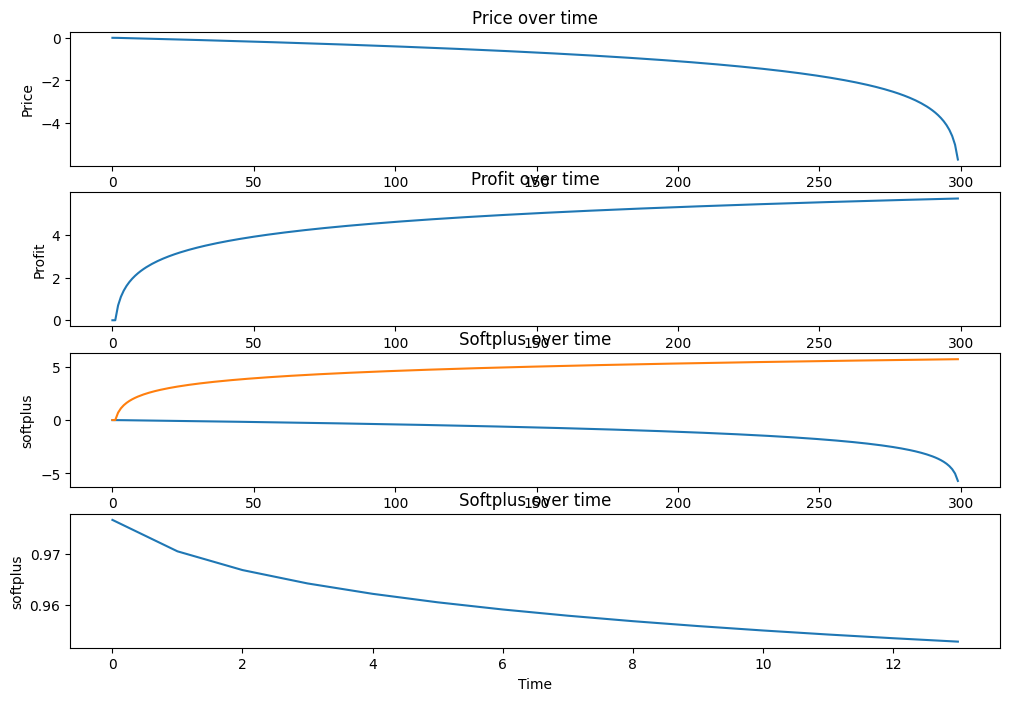

In [27]:
import numpy as np
def display_curves( prices=None, profits=None, softplus=None, rewards=None) :
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    ax1.plot(rewards)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_title('Price over time')

    ax2.plot(profits)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Profit')
    ax2.set_title('Profit over time')        
        
    ax3.plot(rewards)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('softplus')
    ax3.set_title('Softplus over time')
    ax3.plot(profits)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('softplus')
    ax3.set_title('Softplus over time')
    
    ax4.plot(softplus)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('softplus')
    ax4.set_title('Softplus over time')
    
rewards = []
rewards2 = []
rewards3 = []
rewards4 = []
def decaying_log(t , initial_value, decay_rate):
    return initial_value / (1 + decay_rate * np.log(1+t))
decaying_rate = 0.01
initial_value = 1
for i in range(300):
    if i == 0:
        i = 1
    # print(np.log(i),"===============>", np.log(i/60))
    rewards2.append(np.log(i))
    rewards.append( np.log(1 - i/300))
    if i<=150:
        if i in  [10, 20,30, 50, 60, 80, 90, 130,140]:
            rewards3.append(np.log(i*5+1000))
        else:
            rewards3.append(np.log(i))
    elif i >=150:
        if i in [160, 180, 200,250]:
            rewards3.append(-np.log(abs(150-i*4))-np.log(2))
        else:
            rewards3.append(np.log(i) - np.log(2) + np.log(1-i/300))
    if i % 10 == 0 and i < 150:
        rewards4.append(decaying_log(i,initial_value,decaying_rate))
    # else:
        # rewards4.append(decaying_log(i,-2,decaying_rate))
display_curves(rewards=rewards, profits=rewards2, softplus = rewards4)

In [ ]:
!ls

In [8]:
m5short_step_4 = pd.read_csv("final_complete_m5short_timestep_4.csv")
m1short_step_4 = pd.read_csv("final_complete_m1short_timestep_4.csv")
m1long_step_4 = pd.read_csv("final_complete_m1long_timestep_4.csv")
m5long_step_4 = pd.read_csv("final_complete_m5long_timestep_4.csv")

In [ ]:
prices = list(m5long_step_4.iloc[0:9000]["Ask"])
# scaler = MinMaxScaler(feature_range=(0, 1)).fit(np.array([0,0,20]).reshape(-1,1))
# scaler.transform(np.array(reward).reshape(-1,1))[0][0]


import numpy as np

# Assuming you have a list of prices

def display_curves( prices=None, profits=None, softplus=None, rewards=None) :
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    ax1.plot(prices)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_title('Price over time')

    ax1.plot(profits)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Profit')
    ax1.set_title('Profit over time')        
        
#     ax3.plot(rewards)
#     ax3.set_xlabel('Time')
#     ax3.set_ylabel('softplus')
#     ax3.set_title('Softplus over time')
#     ax3.plot(profits)
#     ax3.set_xlabel('Time')
#     ax3.set_ylabel('softplus')
#     ax3.set_title('Softplus over time')
    
#     ax4.plot(softplus)
#     ax4.set_xlabel('Time')
#     ax4.set_ylabel('softplus')
#     ax4.set_title('Softplus over time')
def decaying_log(t , initial_value, decay_rate):
    return initial_value / (1 + decay_rate * np.log(1+t))
# import numpy as np

def decaying_log_profit(t, profit, initial_value, decay_rate_timesteps, decay_rate_profit):
    if profit > 0:
        return initial_value / (1 + decay_rate_timesteps * np.log(1 + t)) / (1 + decay_rate_profit * np.log(1 + profit))
    else:
        return -initial_value / (1 + decay_rate_timesteps * np.log(1 + t)) / (1 + decay_rate_profit * np.log(1 + abs(profit)))

# Convert the prices to a numpy array
prices_arr = np.array(prices)

# Calculate the minimum and maximum values of the prices
min_price = np.min(prices_arr)
max_price = np.max(prices_arr)

# Scale the prices between 0 and 1
scaled_prices = (prices_arr - min_price) / (max_price - min_price)


# Print the scaled prices
# print(scaled_prices)
rewards=[]
highest = 0
profit = 0
position = "sell"
decay_rate_timesteps=0.1
decay_rate_profit=0.1
initial_value = 1
for k,i in enumerate(scaled_prices):
    # if position == "sell":
    #     profit = prices[0]-prices[k]
    # elif position == "buy":
    #     profit = prices[k] - prices[0]

        
    if k > 0 and k < 2000:
        profit = prices[0] - prices[k]
        if profit > highest:
            highest = profit         
        if profit > 0:
            if highest * 0.60 > profit and highest != profit and profit > 20 and k % 10 == 0:
                # rewards.append(decaying_log(k, 1, 0.9) - (highest-profit)/1000)
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
            else:
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
                # rewards.append( decaying_log(k, 1, 0.9) + i) 
        else:
            # rewards.append( decaying_log(k, 1, 0.9) + i) 
            rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
    if k > 2000 and k < 5000:
        profit = prices[k] - prices[2000]
        if profit > highest:
            highest = profit         
        if profit > 0:
            if highest * 0.60 > profit and highest != profit and profit > 20 and k % 10 == 0:
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
                # rewards.append(decaying_log(k, 1, 0.9) - (highest-profit)/1000)
            # print(f"profit=={profit} highest=={highest}")
            else:
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
                # rewards.append( decaying_log(k, 1, 0.9) + i) 
        else:
            # rewards.append( decaying_log(k, 1, 0.9) + i) 
            rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
    if k > 5000:
        profit = prices[5000] - prices[k]
        if profit > highest:
            highest = profit         
        if profit > 0:
            if highest * 0.60 > profit and highest != profit and profit > 20 and k % 10 == 0:
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
                # rewards.append(decaying_log(k, 1, 0.9) - (highest-profit)/1000) 
            else:
                rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
                # rewards.append( decaying_log(k, 1, 0.9) + i) 
        else:
            rewards.append(decaying_log_profit(k, profit, initial_value, decay_rate_timesteps, decay_rate_profit))
            # rewards.append( decaying_log(k, 1, 0.9) + i) 
    # if k % 20 == 0:
    #     if  highest* 0.90 > profit :
    #         rewards.append( decaying_log(k, 1, 0.9) + i + (prices[0] - prices[k])/1000)
    #     elif profit+9 < highest:
    #         print(f"profit {profit} highest {highest}")
    #         rewards.append(decaying_log(k, 1, 0.9) - i + (highest-profit)/1000)
    #     # else:
    #         # rewards.append(decaying_log(k, 1, 0.9) - i + (highest-profit)/1000)
    # else:
    # rewards.append( decaying_log(k, 1, 0.9) + i) 
print(rewards)
display_curves(prices=list(scaled_prices), profits=rewards)
# list(scaled_prices)

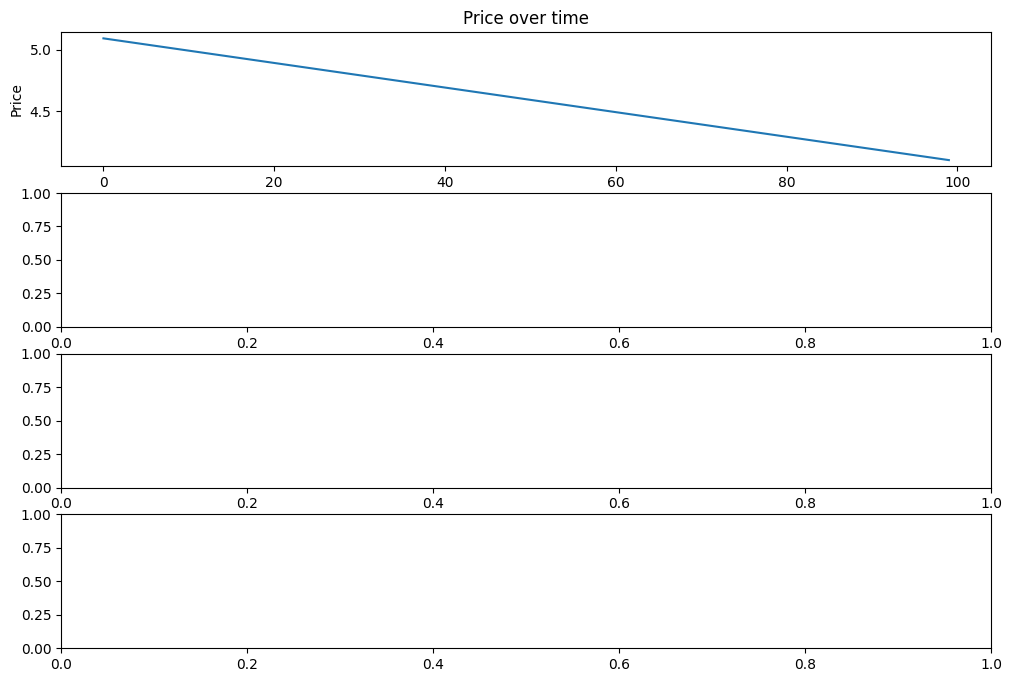

In [153]:
def display_curves( prices=None, profits=None, softplus=None, rewards=None) :
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    ax1.plot(prices)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_title('Price over time')
rewards = []

for k, i in enumerate(range(100)):
    rewards.append((1- i/100)+(1 + 0.67 * np.log(1 + 100)))
# (1 + decay_rate_profit * np.log(1 + profit))
display_curves(prices=rewards)

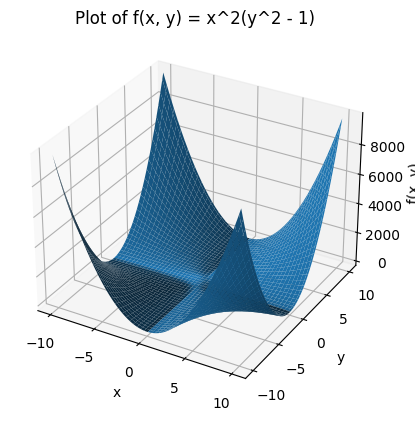

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x, y):
    return x**2 * (y**2 - 1)

# Generate x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Compute the function values for each (x, y) pair
Z = f(X, Y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Plot of f(x, y) = x^2(y^2 - 1)')

# Show the plot
plt.show()


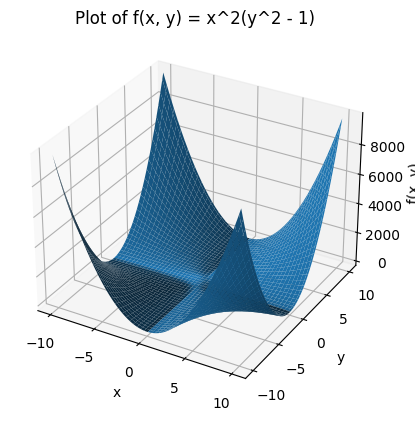

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Define the function
def f(x, y):
    return x**2 * (y**2 - 1)

# Generate x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Compute the function values for each (x, y) pair
Z = f(X, Y)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z)

# Set plot labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Set plot title
plt.title('Plot of f(x, y) = x^2(y^2 - 1)')

# Rotate the plot
def update_rotation(num, plot, ax):
    ax.view_init(elev=num, azim=num)

ani = animation.FuncAnimation(fig, update_rotation, frames=360, fargs=(surface, ax), interval=50)
plt.show()


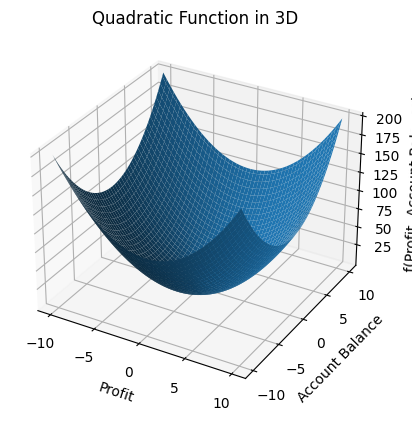

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    profit = x
    account_balance = y
    return profit**2 + account_balance**2

# Generate profit and account balance values
profit = np.linspace(-10, 10, 100)
account_balance = np.linspace(-10, 10, 100)
Profit, Account_Balance = np.meshgrid(profit, account_balance)

# Compute the function values for each (profit, account_balance) pair
Z = f(Profit, Account_Balance)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Profit, Account_Balance, Z)

# Set plot labels
ax.set_xlabel('Profit')
ax.set_ylabel('Account Balance')
ax.set_zlabel('f(Profit, Account Balance)')

# Set plot title
plt.title('Quadratic Function in 3D')

# Show the plot
plt.show()


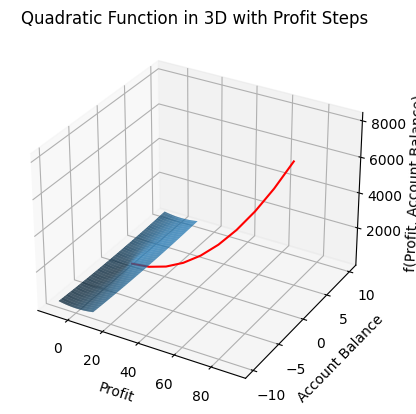

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return x**2 + y**2

# Generate profit and account balance values
profit = np.linspace(-10, 10, 100)
account_balance = np.linspace(-10, 10, 100)
Profit, Account_Balance = np.meshgrid(profit, account_balance)

# Compute the function values for each (profit, account_balance) pair
Z = f(Profit, Account_Balance)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(Profit, Account_Balance, Z)

# Generate the profit steps
profit_steps = np.arange(1, 100, 10)

# Plot the profit steps
ax.plot(profit_steps, np.ones_like(profit_steps) * 0, f(profit_steps, np.zeros_like(profit_steps)), color='red')

# Set plot labels
ax.set_xlabel('Profit')
ax.set_ylabel('Account Balance')
ax.set_zlabel('f(Profit, Account Balance)')

# Set plot title
plt.title('Quadratic Function in 3D with Profit Steps')

# Show the plot
plt.show()


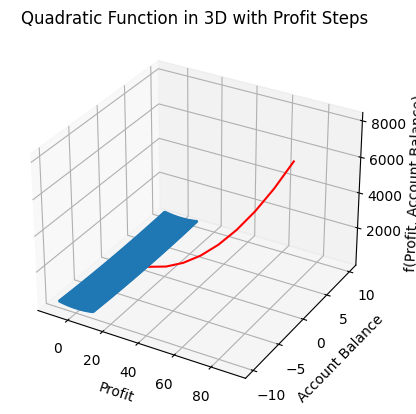

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return x**2 + y**2

# Generate profit and account balance values
profit = np.linspace(-10, 10, 100)
account_balance = np.linspace(-10, 10, 100)
Profit, Account_Balance = np.meshgrid(profit, account_balance)

# Compute the function values for each (profit, account_balance) pair
Z = f(Profit, Account_Balance)

# Create a 3D wireframe plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
wireframe = ax.plot_wireframe(Profit, Account_Balance, Z)

# Generate the profit steps
profit_steps = np.arange(1, 100, 10)

# Plot the profit steps
ax.plot(profit_steps, np.zeros_like(profit_steps), f(profit_steps, np.zeros_like(profit_steps)), color='red')

# Set plot labels
ax.set_xlabel('Profit')
ax.set_ylabel('Account Balance')
ax.set_zlabel('f(Profit, Account Balance)')

# Set plot title
plt.title('Quadratic Function in 3D with Profit Steps')

# Show the plot
plt.show()


In [169]:
import numpy as np

class TradingAgent:
    def __init__(self):
        self.account_balance = 1000.0

    def take_action(self):
        # Replace this with your actual trading logic
        # Perform actions such as buying, selling, or holding assets
        pass

    def update(self, profit):
        # Update the account balance based on the profit
        self.account_balance += profit

    def get_reward(self, profit):
        # Compute the reward using the suggested reward function
        return profit - 0.01 * np.abs(self.account_balance)

# Initialize the trading agent
agent = TradingAgent()

# Perform episodes of trading
num_episodes = 10
for episode in range(num_episodes):
    # Assume the agent takes an action and receives a profit
    action = agent.take_action()
    profit = 200.0  # Replace with your actual profit calculation

    # Update the agent and get the reward
    agent.update(profit)
    reward = agent.get_reward(profit)

    # Print the reward and account balance
    print("Episode:", episode+1)
    print("Reward:", reward)
    print("Account Balance:", agent.account_balance)
    print()


Episode: 1
Reward: 188.0
Account Balance: 1200.0

Episode: 2
Reward: 186.0
Account Balance: 1400.0

Episode: 3
Reward: 184.0
Account Balance: 1600.0

Episode: 4
Reward: 182.0
Account Balance: 1800.0

Episode: 5
Reward: 180.0
Account Balance: 2000.0

Episode: 6
Reward: 178.0
Account Balance: 2200.0

Episode: 7
Reward: 176.0
Account Balance: 2400.0

Episode: 8
Reward: 174.0
Account Balance: 2600.0

Episode: 9
Reward: 172.0
Account Balance: 2800.0

Episode: 10
Reward: 170.0
Account Balance: 3000.0



In [99]:
# m5long = pd.read_csv("final_m5long.csv")
# final_m1short.to_csv("final_complete_m1short_timestep_4.csv", index=False)
# m5short = pd.read_csv("final_m5short.csv")
# m1long = pd.read_csv("final_m1long.csv")
# m1short = pd.read_csv("final_complete_m1short.csv")
# m1short = pd.read_csv("final_m1short.csv")


action = 3
state_size = (1, 3, 224, 224, 3)
chart_decorator = ChartDecorator()
env = ForexCustomEnv(m1short_step_4 ,m5short_step_4, m1long_step_4, m5long_step_4,chart_decorator)
agent = Agent(state_size, action, env)
# agent.env = env 
agent.epsilon = 0.001
agent.env.account_balance = 1000
# agent.load()  
agent.critic.summary()  


Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_28 (TimeDi  (None, 1, 128)           4985664   
 stributed)                                                      
                                                                 
 time_sformer_block_28 (Time  (None, 1, 128)           396032    
 SformerBlock)                                                   
                                                                 
 dense_225 (Dense)           (None, 1, 128)            16512     
                                                                 
 dense_226 (Dense)           (None, 1, 64)             8256      
                                                                 
 dense_227 (Dense)           (None, 1, 3)              195       
                                                                 
Total params: 5,406,659
Trainable params: 5,406,659
N

In [173]:
def reward_function(agent, current_state, action, next_state):
    trade_profit = next_state['balance'] - current_state['balance']
    holding_time = next_state['time'] - current_state['time']
    trade_frequency_penalty = 0

    if agent.last_trade_time is not None:
        time_since_last_trade = current_state['time'] - agent.last_trade_time
        if time_since_last_trade < min_time_between_trades:
            trade_frequency_penalty = trade_penalty

    reversal_reward = 0
    if action == 'close_trade' or action == 'idle':
        if correctly_identified_reversal(current_state, next_state):
            reversal_reward = reversal_bonus

    reward = trade_profit - holding_time_penalty * holding_time - trade_frequency_penalty + reversal_reward

    return reward



def correctly_identified_reversal(current_state, next_state):
    # Placeholder for your reversal detection logic
    return True

# Dummy data
class DummyAgent:
    def __init__(self):
        self.last_trade_time = None

dummy_agent = DummyAgent()
current_state = {'balance': 1000, 'time': 10}
next_state = {'balance': 1090, 'time': 37}
action = 'close_trade'

# Parameters
holding_time_penalty = 1
min_time_between_trades = 5
trade_penalty = 10
reversal_bonus = 20

# Call the reward function
reward = reward_function(dummy_agent, current_state, action, next_state)
print("Reward:", reward)


Reward: 83


In [ ]:
def moving_average(data, window):
    return sum(data[-window:]) / window

def correctly_identified_reversal(current_state, next_state):
    short_window = 5
    long_window = 20

    current_short_ma = moving_average(current_state['price_history'], short_window)
    current_long_ma = moving_average(current_state['price_history'], long_window)
    next_short_ma = moving_average(next_state['price_history'], short_window)
    next_long_ma = moving_average(next_state['price_history'], long_window)

    # Check for a bullish reversal (short MA crosses above long MA)
    bullish_reversal = current_short_ma < current_long_ma and next_short_ma > next_long_ma

    # Check for a bearish reversal (short MA crosses below long MA)
    bearish_reversal = current_short_ma > current_long_ma and next_short_ma < next_long_ma

    return bullish_reversal or bearish_reversal


In [174]:
def correctly_identified_reversal(current_state, next_state):
    # Placeholder for your reversal detection logic
    return True

# Dummy data
class DummyAgent:
    def __init__(self):
        self.last_trade_time = None

dummy_agent = DummyAgent()
current_state = {'balance': 1000, 'time': 10}
next_state = {'balance': 1020, 'time': 15}
action = 'close_trade'

# Parameters
holding_time_penalty = 1
min_time_between_trades = 5
trade_penalty = 10
reversal_bonus = 20

# Call the reward function
reward = reward_function(dummy_agent, current_state, action, next_state)
print("Reward:", reward)


# Dummy data
dummy_agent = DummyAgent()
current_state = {
    'balance': 1000,
    'time': 10,
    'price_history': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
}
next_state = {
    'balance': 1020,
    'time': 15,
    'price_history': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
}
action = 'close_trade'

# Call the reward function
reward = reward_function(dummy_agent, current_state, action, next_state)
print("Reward:", reward)


Reward: 35
Reward: 35


1/1 [==============================] - 0s 51ms/step


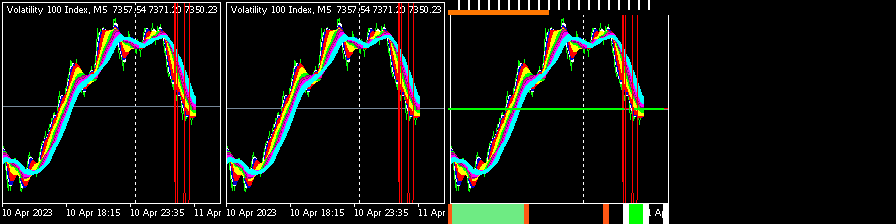

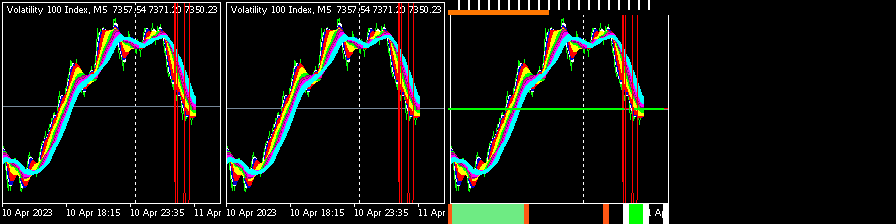

1/1 [==============================] - 0s 52ms/step
DBG: reward in train 0.05 target_f_values[0.93346834]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       100 |        2 |      0 |        0 |      1000 |   7357.6 |  7359.27 |                 0.933468 |   0.0406653 | 0.00,1.00,0.00    | 0.00,1.00,0.04       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+---

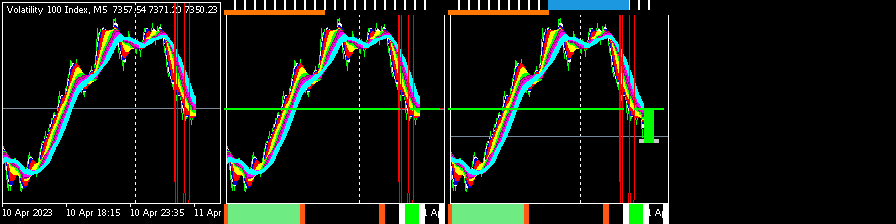

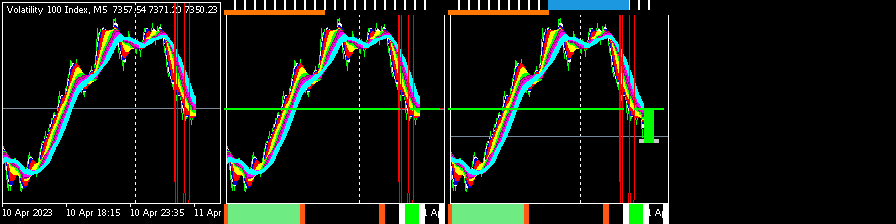

1/1 [==============================] - 0s 50ms/step
DBG: reward in train 0.7892217344493656 target_f_values[0.9324008]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       200 |        2 |      0 |    84.38 |      1000 |   7357.6 |  7273.22 |                 0.932401 |    0.779898 | 0.00,1.00,0.00    | 0.00,1.00,0.78       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

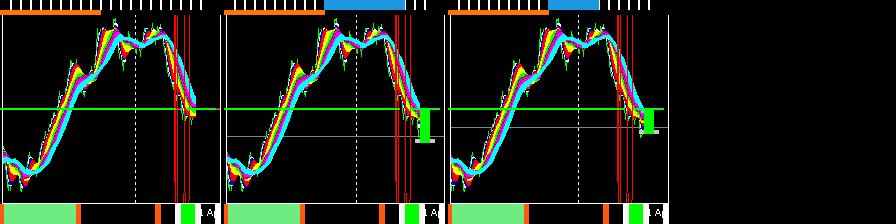

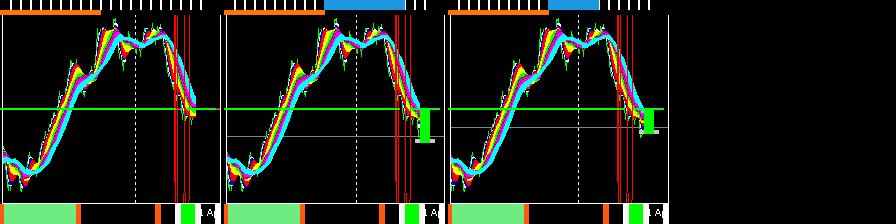

1/1 [==============================] - 0s 51ms/step
DBG: reward in train 2.1796656664374763 target_f_values[0.93152744]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       300 |        2 |      0 |       55 |      1000 |   7357.6 |   7302.6 |                 0.931527 |     2.17035 | 0.00,1.00,0.00    | 0.00,1.00,2.17       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+---

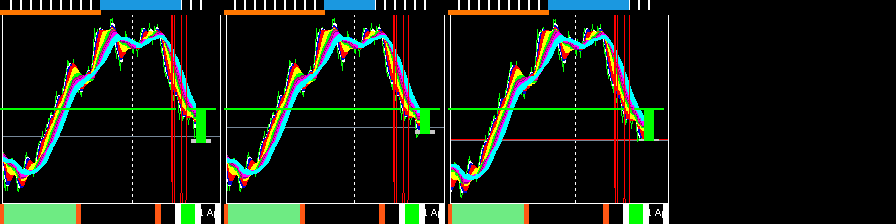

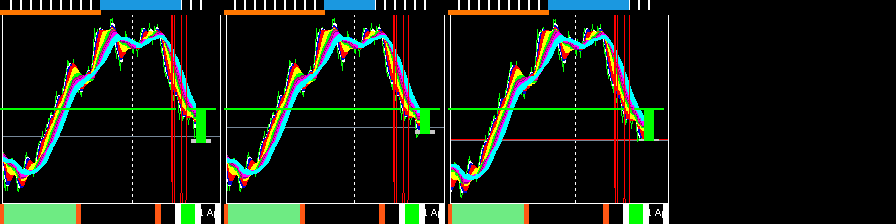

1/1 [==============================] - 0s 52ms/step
DBG: reward in train 3.567301046755588 target_f_values[0.9312448]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       400 |        2 |      0 |    82.97 |      1000 |   7357.6 |  7274.63 |                 0.931245 |     3.55799 | 0.00,1.00,0.00    | 0.00,1.00,3.56       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

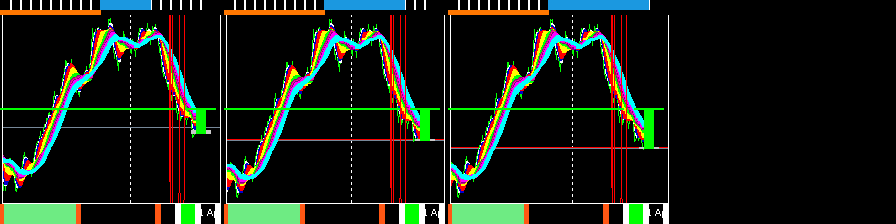

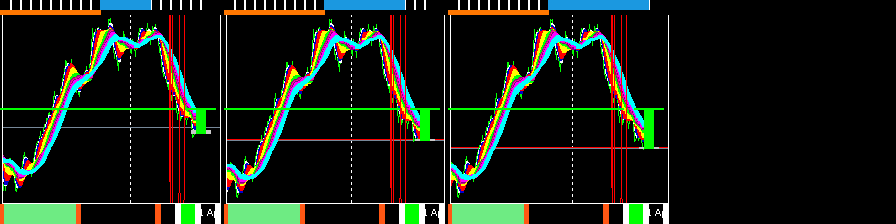

1/1 [==============================] - 0s 51ms/step
DBG: reward in train 4.329548861478584 target_f_values[0.9315159]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       500 |        2 |      0 |   108.89 |      1000 |   7357.6 |  7248.71 |                 0.931516 |     4.32023 | 0.00,1.00,0.00    | 0.00,1.00,4.32       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

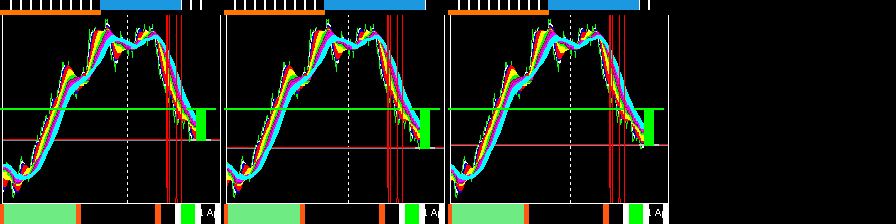

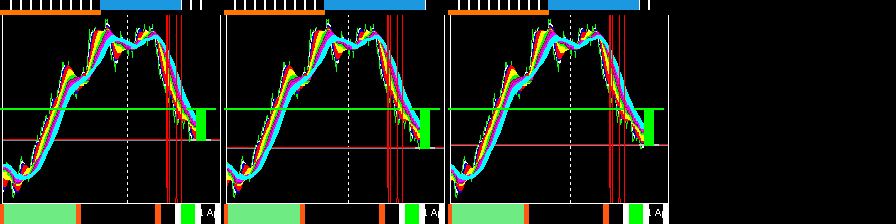

1/1 [==============================] - 0s 51ms/step
DBG: reward in train 4.4664756118748565 target_f_values[0.9321135]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       600 |        2 |      0 |    96.92 |      1000 |   7357.6 |  7260.68 |                 0.932114 |     4.45715 | 0.00,1.00,0.00    | 0.00,1.00,4.46       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

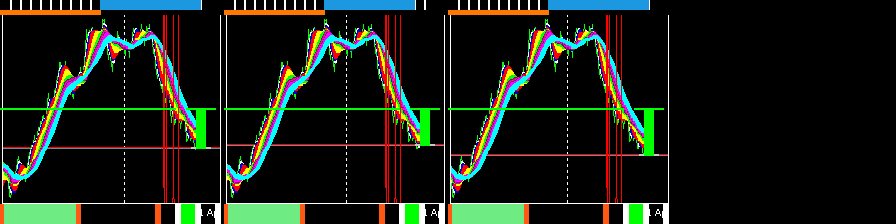

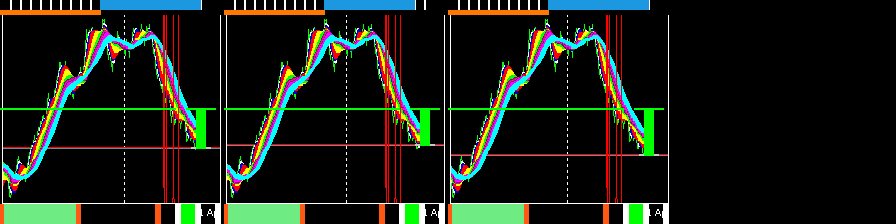

1/1 [==============================] - 0s 56ms/step
DBG: reward in train 4.633094474649099 target_f_values[0.93290377]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       700 |        2 |      0 |   127.95 |      1000 |   7357.6 |  7229.65 |                 0.932904 |     4.62377 | 0.00,1.00,0.00    | 0.00,1.00,4.62       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

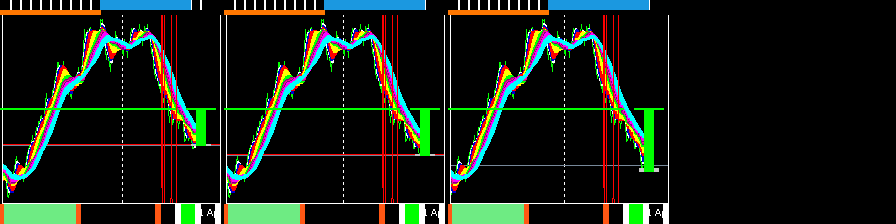

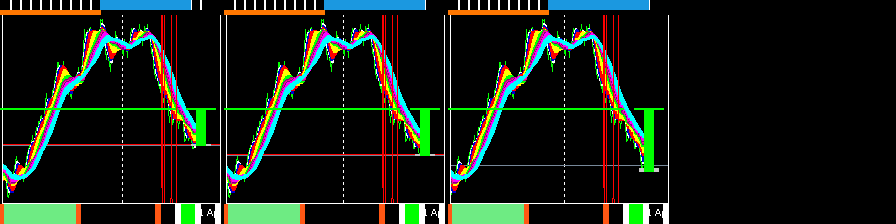

1/1 [==============================] - 0s 53ms/step
DBG: reward in train 4.766834171964018 target_f_values[0.93380743]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       800 |        2 |      0 |   157.53 |      1000 |   7357.6 |  7200.07 |                 0.933807 |      4.7575 | 0.00,1.00,0.00    | 0.00,1.00,4.76       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

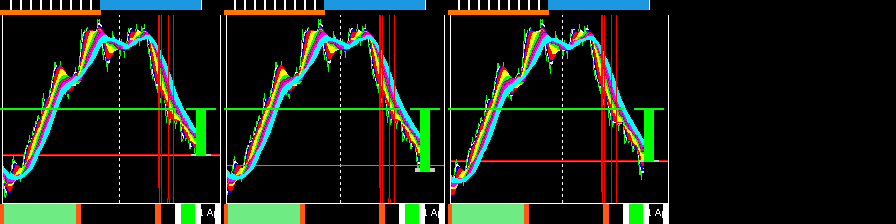

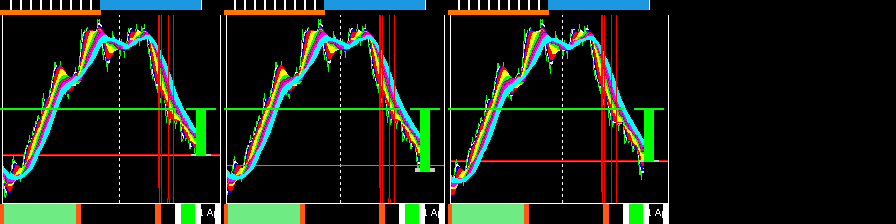

1/1 [==============================] - 0s 54ms/step
DBG: reward in train 4.885514616952569 target_f_values[0.93477803]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |       900 |        2 |      0 |   136.55 |      1000 |   7357.6 |  7221.05 |                 0.934778 |     4.87617 | 0.00,1.00,0.00    | 0.00,1.00,4.88       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

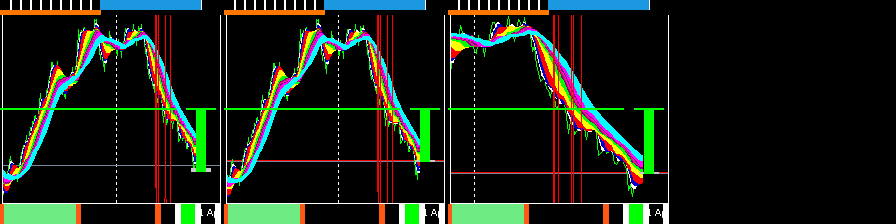

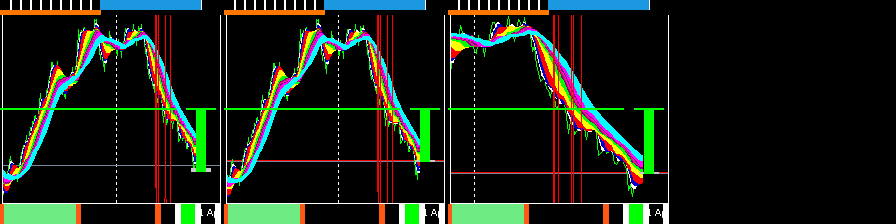

1/1 [==============================] - 0s 54ms/step
DBG: reward in train 4.946854732499623 target_f_values[0.93578815]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1000 |        2 |      0 |   131.22 |      1000 |   7357.6 |  7226.38 |                 0.935788 |      4.9375 | 0.00,1.00,0.00    | 0.00,1.00,4.94       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

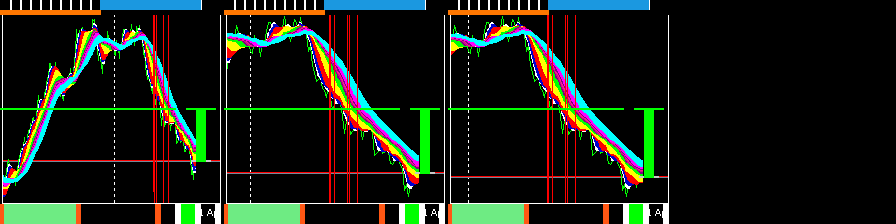

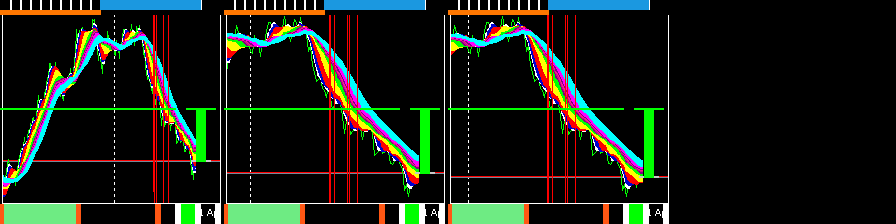

1/1 [==============================] - 0s 55ms/step
DBG: reward in train 4.933363006719378 target_f_values[0.93682116]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1100 |        2 |      0 |   141.66 |      1000 |   7357.6 |  7215.94 |                 0.936821 |       4.924 | 0.00,1.00,0.00    | 0.00,1.00,4.92       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

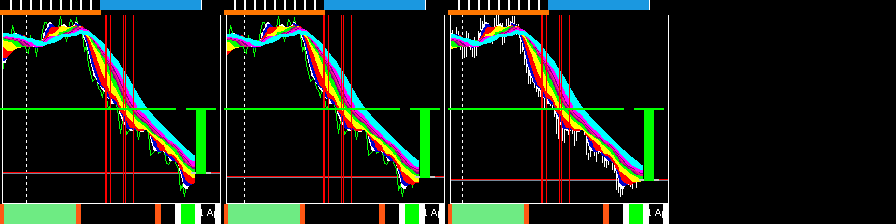

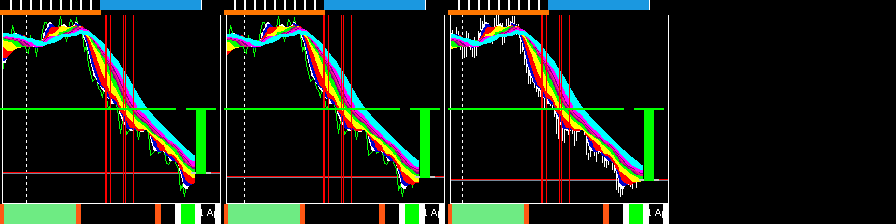

1/1 [==============================] - 0s 59ms/step
DBG: reward in train 4.92949047483759 target_f_values[0.93786764]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1200 |        2 |      0 |   148.36 |      1000 |   7357.6 |  7209.24 |                 0.937868 |     4.92011 | 0.00,0.00,1.00    | 0.00,0.00,4.92       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

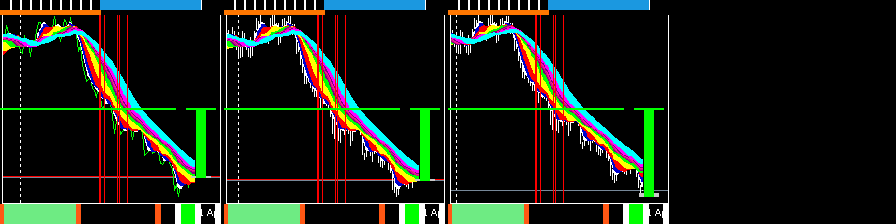

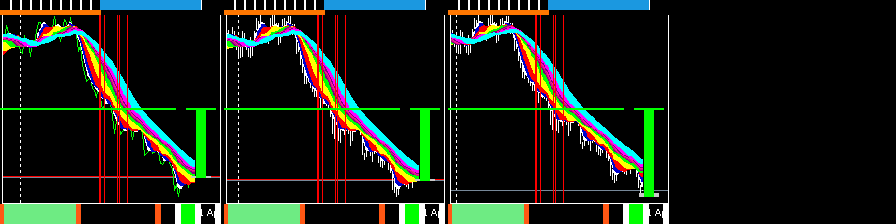

1/1 [==============================] - 0s 55ms/step
DBG: reward in train 5.022755662803881 target_f_values[0.9389218]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1300 |        2 |      0 |   211.35 |      1000 |   7357.6 |  7146.25 |                 0.938922 |     5.01337 | 0.00,0.00,1.00    | 0.00,0.00,5.01       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

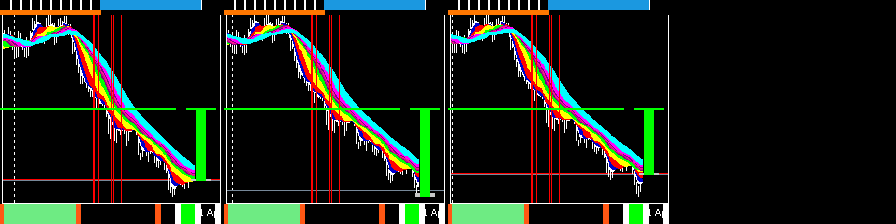

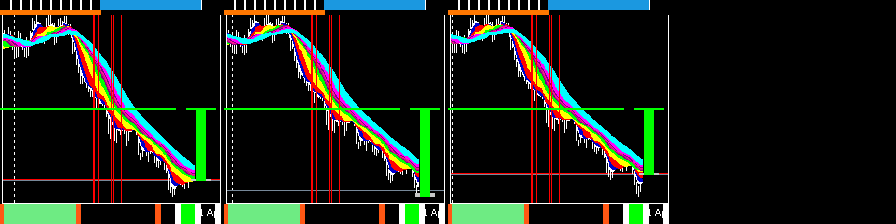

1/1 [==============================] - 0s 52ms/step
DBG: reward in train 5.137497898652761 target_f_values[0.93998045]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1400 |        2 |      0 |   175.08 |      1000 |   7357.6 |  7182.52 |                  0.93998 |      5.1281 | 0.00,0.00,1.00    | 0.00,0.00,5.13       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+----

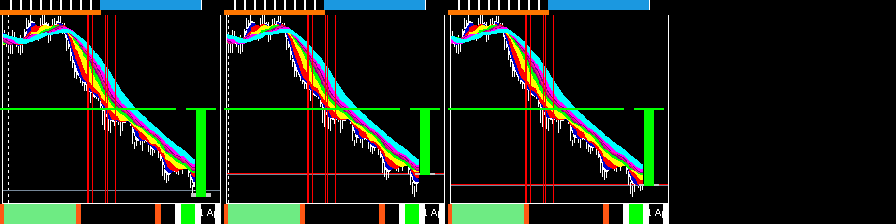

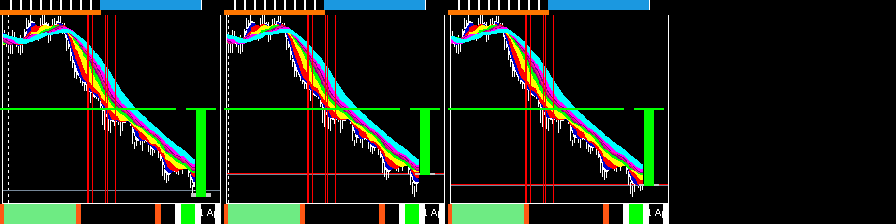

1/1 [==============================] - 0s 56ms/step
DBG: reward in train 5.226491425670927 target_f_values[0.9410415]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1500 |        2 |      0 |   204.75 |      1000 |   7357.6 |  7152.85 |                 0.941042 |     5.21708 | 0.00,0.00,1.00    | 0.00,0.00,5.22       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

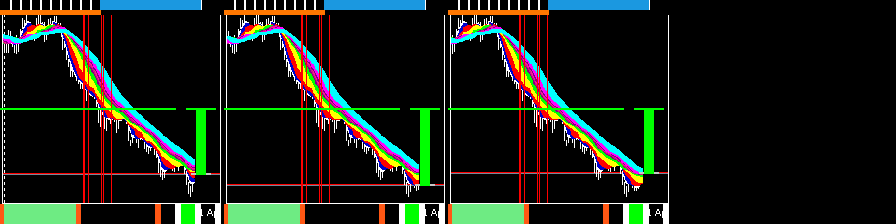

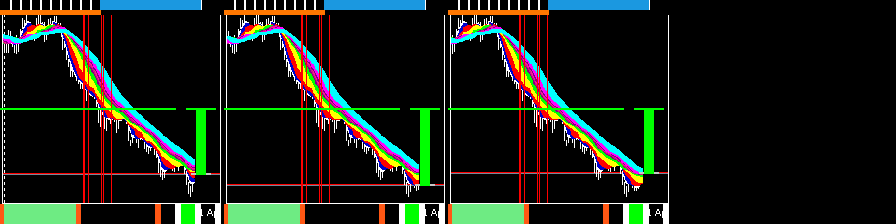

1/1 [==============================] - 0s 55ms/step
DBG: reward in train 5.246580724202841 target_f_values[0.9421039]
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-------------+-------------------+----------------------+
|   episode |   epsilon |   counter |   action |   done |   profit |   balance |   Eprice |   Cprice |   critic target_f_values |   advantage | actor pred qvls   | fit actor q_values   |
+===========+===========+===========+==========+========+==========+===========+==========+==========+==========================+=============+===================+======================+
|         0 |     0.001 |      1600 |        2 |      0 |   172.76 |      1000 |   7357.6 |  7184.84 |                 0.942104 |     5.23716 | 0.00,0.00,1.00    | 0.00,0.00,5.24       |
+-----------+-----------+-----------+----------+--------+----------+-----------+----------+----------+--------------------------+-----

KeyboardInterrupt: 

In [100]:
# def train(self, num_episodes, start= 20, end = 9000, _step = 1, t_action = None, draw = False, epsilon = 0.001, m1short_step_4 = None ,m5short_step_4 = None, m1long_step_4 = None, m5long_step_4 = None):
for _ in range(1000):
    print(f"Episode {_}")
    if _ < 1:
        agent.epsilon  = 1 
        # agent.train(40,  False, agent.epsilon, m1short_step_4 ,m5short_step_4, m1long_step_4, m5long_step_4)
    #if _ >= 3: 
    agent.epsilon = 0.001
    agent.train(1,  start=100, end = 2000, _step= 100, t_action = 2 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4)#wrong values
    agent.train(1,  start=2100, end = 4000, _step= 100, t_action = 1 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4)#wrong values
    agent.train(1,  start=100, end = 2000, _step= 100, t_action = 1 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4) #correct values
    agent.train(1,  start=2100, end = 4000, _step= 100, t_action = 2 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4)#correct values
    print("Running Tests : ")
    agent.train(1,  start=100, end = 2000, _step= 100, t_action = 0 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4)
    agent.train(1,  start=2100, end = 4000, _step= 100, t_action = 0 ,draw=True, epsilon=agent.epsilon, m1short_step_4=m1short_step_4 ,m5short_step_4=m5short_step_4, m1long_step_4=m1long_step_4, m5long_step_4=m5long_step_4)
    


In [101]:
agent.save()